# Summary

# Content:
    1) Import library
    2) Configuration
    3) Define Functions
    4) Basic Checks
    5) Export Data Description
    6) Data Cleaning
        6.1) Drop columns
            6.1.1) Drop empty columns
            6.1.2) Drop unilabel/univalue columns
        6.2) Transaction
            6.2) Fix Data Quality Issue in 'Fruit Size Code' 
        6.3) Dispatched
    7) Convert to Time Series Data
        7.1) Transaction
            7.1.1) Drop duplicated transactions
        7.2) Dispatched

# Coding

## 1) Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from scipy.stats import skew,kurtosis
import datetime

In [2]:
%matplotlib inline
# to view all columns
pd.set_option('display.max_columns',500)
plt.style.use('seaborn')

## 2) Configuration

In [3]:
filepath_1='C:/Users/Nan/Documents/GitHub_Data/TransactionDetails.csv'
filepath_2='C:/Users/Nan/Documents/GitHub_Data/Dispatched.csv'
filename_1=filepath_1.rstrip('.csv')
filename_2=filepath_2.rstrip('.csv')
transaction=pd.read_csv(filepath_1)
dispatched=pd.read_csv(filepath_2)

C:\Users\Nan\AppData\Local\conda\conda\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7,16,27,29,33,38,60,64,95,100) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Nan\AppData\Local\conda\conda\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (9,22,23,53,65,70,96,97,121,122,123,125,132) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 3) Define Functions

In [4]:
def get_datatype(arg_df):
    
    col_bool=[]
    col_object=[]
    col_number=[]
    col_catogory=[]
    
    for col in arg_df.columns:
        datatype=arg_df[col].dtypes
        if datatype==bool:
            col_bool.append(col)
        elif datatype==object :
            col_object.append(col)
        elif str(datatype)=='category':
            col_catogory.append(col)
        else:
            col_number.append(col)
    print('This dataset has {} Columns\nbool\t:{} \nobject\t:{}  \ncategory:{} \nnumeric\t:{} '
          .format(len(arg_df.columns),len(col_bool),len(col_object),len(col_catogory),len(col_number)))
    
    del arg_df
    gc.collect()
    
    return col_bool,col_object,col_catogory,col_number

In [5]:
def summary_object(arg_df):
    
    object_list=[]
    category_list=[]
    bool_list=[]
    unilabel_list=[]
    missing_list=[]
    
    for c in arg_df.columns:
        if arg_df[c].dtypes==object:
            object_list.append(c)
        elif str(arg_df[c].dtypes)=='category':
            category_list.append(c)
        elif arg_df[c].dtypes==bool:
            bool_list.append(c)
    if len(object_list)+len(category_list)+len(bool_list)>0:    
        index_list=['Count','Unique','Missing (%)','Top','Top (%)','Bottom','Bottom (%)']
        df_summary=pd.DataFrame(data=np.zeros((len(index_list),len(object_list))),index=index_list,columns=object_list)

        for col in object_list+category_list+bool_list:
            vc=arg_df[col].value_counts().reset_index()
            df_summary.loc['Count',col]=(arg_df[col].count())
            df_summary.loc['Unique',col]=len(arg_df[col].unique())
            df_summary.loc['Missing (%)',col]=arg_df[col].isna().mean()*100
            df_summary.loc['Top',col]=vc.iloc[0,0]
            df_summary.loc['Top (%)',col]=vc.iloc[0,1]/len(arg_df)*100
            if len(arg_df[col].unique())>1:
                df_summary.loc['Bottom',col]=vc.iloc[-1,0]
                df_summary.loc['Bottom (%)',col]=vc.iloc[-1,1]/len(arg_df)*100
            else:
                unilabel_list.append(col)
            if df_summary.loc['Missing (%)',col]==100:
                missing_list.append(col)
                
        df_summary=df_summary.T.sort_values(['Missing (%)','Unique'],ascending=False)
        df_summary=df_summary[(df_summary['Unique']>1) & (df_summary['Missing (%)']!=100)]
        df_summary.reset_index(inplace=True)
        df_summary.index=df_summary.index+1
        df_summary.columns=['Attribute']+index_list
        
        print('SUMMARY OF {} NON-NUMERICAL ATTRIBUTES:\n'.format(
            len(object_list)+len(category_list)+len(bool_list)))
        if len(object_list)>0:
            print('{} Object Columns'.format(len(object_list)))
        if len(category_list)>0:
            print('{} Categorical Columns'.format(len(category_list)))
        if len(bool_list)>0:
            print('{} Bool Columns'.format(len(bool_list)))
        if len(unilabel_list)>0:
            print('\n{} Columns with Single Label : \n{}'.format(len(unilabel_list),unilabel_list))
        if len(missing_list)>0:
            print('\n{} Empty Columns: \n{}'.format(len(missing_list),missing_list))   
            
        del arg_df,object_list,vc,index_list,unilabel_list,missing_list
        gc.collect()
        return df_summary
    else:
        print('No Non-Numerical Attributes')
        
def summary_numerical(arg_df):

    target_list=[]
    missing_list=[]
    zero_skew_list=[]
    
    for c in arg_df.columns:
        datatype=arg_df[c].dtypes
        if datatype != object and datatype != bool and str(datatype) != 'category':
            target_list.append(c)
    if len(target_list)>0:
        from scipy.stats import skew,kurtosis
        
        index_list=['Count','Missing (%)','Mean','Median','Min','Max','Skewness','Kurtosis']
        df_summary=pd.DataFrame(data=np.zeros((len(index_list),len(target_list))),
                                index=index_list,columns=target_list)
        for col in target_list:
            df_summary.loc['Count',col]=arg_df[col].count()
            df_summary.loc['Missing (%)',col]=arg_df[col].isna().mean()*100
            if df_summary.loc['Missing (%)',col]!=100:
                df_summary.loc['Mean',col]=arg_df[col].mean()
                df_summary.loc['Median',col]=arg_df[col].median()
                df_summary.loc['Min',col]=arg_df[col].min()
                df_summary.loc['Max',col]=arg_df[col].max()
                df_summary.loc['Skewness',col]=skew(arg_df[col])
                if df_summary.loc['Skewness',col]==0:
                    zero_skew_list.append(col)
                df_summary.loc['Kurtosis',col]=kurtosis(arg_df[col])
            else:
                missing_list.append(col)
                
        df_summary=df_summary.T.sort_values(['Missing (%)','Skewness'],ascending=False)
        df_summary=df_summary[(df_summary['Skewness']!=0) & (df_summary['Missing (%)']!=100)]
        df_summary.reset_index(inplace=True)
        df_summary.index=df_summary.index+1
        df_summary.columns=['Attribute']+index_list
        
        print('SUMMARY OF {} NUMERICAL ATTRIBUTES:'.format(len(target_list)))
        if len(zero_skew_list)>0:
            print('\n{} Columns with Single Value: \n{}'.format(len(zero_skew_list),zero_skew_list))
        if len(missing_list)>0:
            print('\n{} Empty Columns: \n{}'.format(len(missing_list),missing_list))
        del arg_df,target_list,index_list
        gc.collect()

        return df_summary
    else:
        print('No Numerical Attributes')

In [6]:
def export_Data_Description(arg_df,**kwarg):
    from scipy.stats import skew
    data_description=pd.DataFrame()
    for c in arg_df.columns:
        data_description.loc[c,'Datatype']=arg_df[c].dtypes
        data_description.loc[c,'Missing%']='{:.3f}'.format((len(arg_df[c])-arg_df[c].count())/len(arg_df[c])*100)
        if (len(arg_df[c])-arg_df[c].count())/len(arg_df[c])*100!=100:
            if arg_df[c].dtypes==object:
                data_description.loc[c,'Unique']=len(arg_df[c].unique())
                if len(arg_df[c].unique())==1:
                    data_description.loc[c,'Remark']='Dropped because this column has only single lable'
                else:
                    data_description.loc[c,'Remark']='Frequent: {} ({:.3f} %)'.format(
                        arg_df[c].mode()[0],arg_df[arg_df[c]==arg_df[c].mode()[0]][c].count()/len(arg_df[c])*100)
            else:
                if skew(arg_df[c])==0:
                    data_description.loc[c,'Unique']=1
                    data_description.loc[c,'Remark']='Dropped because this column has only single value'
                else:
                    data_description.loc[c,'Remark']='MAX: {:.3f} MIN: {:.3f} MEAN: {:.3f} STD: {:.3f}'.format(
                        arg_df[c].max(),arg_df[c].min(),arg_df[c].mean(),arg_df[c].std())
        else:
            data_description.loc[c,'Remark']='Dropped because this column is empty'
    data_description.reset_index(inplace=True)
    data_description.index=data_description.index+1
    data_description=data_description.rename(columns={'index':'Attribute'})
    if ('surfix' in kwarg):
        data_description.to_excel('data_description_{}.xlsx'.format(kwarg['surfix']))
    else:
        import datetime
        currentDT = datetime.datetime.now()
        time=str(currentDT.year)+'-'+str(currentDT.month)+'-'+str(currentDT.day)+' '+str(currentDT.hour)+str(currentDT.minute)+str(currentDT.second)
        data_description.to_excel('data_description_{}.xlsx'.format(time))

In [7]:
def rectify_to_category(arg_df,actual_col_list):
    
    object_list=[]
    '''
    for c in arg_df.columns:
        if arg_df[c].dtypes==object or str(arg_df[c].dtypes)=='category':
            object_list.append(c)
    if len(object_list)>0: 
        for column in [c for c in object_list if c not in actual_col_list]: '''
    for c in arg_df.columns:
        if arg_df[c].dtype!=bool:
            object_list.append(c)
    if len(object_list)>0:
        for columns in [c for c in object_list if c not in actual_col_list]:
            arg_df[columns]=arg_df[columns].astype('category',inplace=True)
        print('Change Datatype of {} Column to Category : \n{}'.format(len(object_list),object_list))

In [8]:
def drop_unilable_column(arg_df):
    
    target_list=[]
    object_list=[]
    number_list=[]
    for c in arg_df.columns:
        if (arg_df[c].dtypes==object) | (str(arg_df[c].dtypes)=='category') | (arg_df[c].dtypes==bool):
            object_list.append(c)
        else:
            number_list.append(c)
    if len(object_list)>0:    
        for c in object_list:
            if len(arg_df[c].unique())==1:
                target_list.append(c)
    
    if len(number_list)>0:   
        from scipy.stats import skew
        for c in number_list:
            if skew(arg_df[c])==0:
                target_list.append(c)
                
    if len(target_list)>0:
        arg_df.drop(columns=target_list,axis='columns',inplace=True)
        print('Drop {} Columns with Single Label:\n{}'.format(len(target_list),target_list))
    else: 
        print('No Columns with Single Label/Value')

    del target_list,object_list

In [9]:
def drop_empty_column(arg_df):
    target_list=[]
    for c in arg_df.columns:
        if arg_df[c].count()==0:
            target_list.append(c)
    if len(target_list)>0:
        arg_df.drop(columns=target_list,axis=1,inplace=True)
        print('Delete {} Empty Column : \n{}'.format(len(target_list),target_list))
    else:
        print('No Empty Column')

In [10]:
def export_description(arg_df,str_1,str_2):
    arg_df.groupby(str_1)[str_2].value_counts(dropna=False,
                                              ascending=False).to_frame().to_csv('{}.csv'.format(str_2))

## 4) Basic Checks

## 4.1) Dataset -Transaction

In [11]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277075 entries, 0 to 277074
Columns: 103 entries, Activity Team Code to Variety Code
dtypes: bool(2), float64(44), int64(11), object(46)
memory usage: 214.0+ MB


In [12]:
bool_list,object_list,cat_list,num_list=get_datatype(transaction)

This dataset has 103 Columns
bool	:2 
object	:46  
category:0 
numeric	:55 


In [13]:
transaction.head(3)

,Activity Team Code,Colour Card,Conditioning Indicator Code,Coolstore Code,Customer Label Code,Disorder Indicator Code,Document Reference,Doi Number,Dry Matter Code,EDISent Date Time,EDIProcessed Date Time,Event Type Code,Firmness,Fruit,Fruit Indicator Code,Fruit Per Pack,Fruit Size Code,Global Gap Brc Indicator Code,Growing Method,Grower Number,Is MVQDestination Pallet,Is Zespri,Japan Sub Brand Code,Labelling Indicator Code,Location Column,Location Height,Location Room Code,Location Row Code,Location Request Number,Location Mission Request Destination,Location Mission Request Reason,Loss Code,Marketer,Material Number,Maturity Area Code,MVQDestination Material Number,MVQDestination Pallet Number,MVQSource Pallet Number,New Value,Ok Until Date,Pack Code,Pack Date,Packed Fruit,Packhouse Code,Pack Indicator Code,Pack Label Code,Pack Make,Packrun Batch Code,Packrun Description,Packs,Pack Type,Pallet Adjustment Reason Code,Pallet Adjustment Reason Description,Pallet Number,Pallet Rework Count,Pallet Note Type,Pallet Note Text,Passed Or Failed,Pest Indicator Code,Plant Code,Previous Value,Product Restriction Action,Product Restriction Code,Protocol Code,Purchase Pool Code,Quality Inspection Indicator Code,Quantity B,Quantity D,Quantity F,Quantity M,Quantity P,Quantity R,Quantity S,Quantity X,Quantity Y,Quantity Z,Reason Code,Reason Description,Record Type,Record Type Code,Record Type Description,Reference Note,Rf Id Tag,Room,Sample Quantity,Scope,Source,Source Pallet Number,Storage Method Code,Storing Characteristic Code,Supplier Code,Temperature Indicator Code,Transaction Date,Transaction Date Time,Transaction Sub Type Code,Transfer To Coolstore,Transfer To Supplier,Trays,Trial Packing Indicator Code,Username,Value Type,Zil Message Number,Variety Code
0,NaN,NaN,N,3TPK,N,NaN,NaN,NaN,Y,NaN,NaN,SET,NaN,13000,N,130,42,1,CK,NaN,False,False,N,LG,NaN,0.0,UNKNOWN,NaN,0,NaN,NaN,NaN,ZIL,62853,NaN,NaN,NaN,NaN,Q02-03-4-1,21/07/2019 12:00:00 AM,41236,6/06/2019 12:00:00 AM,13000,3TPP,N,N,KC1,NaN,NaN,100,ENMBKC1,NaN,NaN,59717008,0,NaN,NaN,N,N,1103,Q02-03-3-1,NaN,NaN,N,01,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOC,LOC,Locate Pallets,NaN,NaN,UNKNOWN---0,NaN,Internal,NaN,NaN,CN,N,434,N,1/07/2019 12:00:10 AM,1/07/2019 12:00:10 AM,MLA,NaN,NaN,309.523810,N,agubs,Location,NaN,HW
1,NaN,NaN,N,3TPK,N,NaN,NaN,NaN,Y,NaN,NaN,SET,NaN,9216,N,36,36,1,CK,NaN,False,False,N,LG,1.0,1.0,Q52,RACK,0,NaN,NaN,NaN,ZIL,62809,NaN,NaN,NaN,NaN,Q14-15-9-2,21/07/2019 12:00:00 AM,41717,5/06/2019 12:00:00 AM,9216,3TPP,N,N,KC1,NaN,NaN,256,E3ITKC1,NaN,NaN,59708334,0,NaN,NaN,N,N,1103,Q14-02-10-1,NaN,NaN,N,01,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOC,LOC,Locate Pallets,NaN,NaN,Q52-RACK-1-1,NaN,Internal,NaN,NaN,CN,N,434,N,1/07/2019 12:00:15 AM,1/07/2019 12:00:15 AM,MTA,NaN,NaN,256.000000,N,jaspsi,Location,NaN,HW
2,NaN,NaN,N,3TPK,N,NaN,NaN,NaN,Y,NaN,NaN,SET,NaN,12650,N,115,39,1,CK,NaN,False,False,N,LG,NaN,0.0,UNKNOWN,NaN,0,NaN,NaN,NaN,ZIL,65735,NaN,NaN,NaN,NaN,Q14-02-10-1,14/07/2019 12:00:00 AM,76332,1/06/2019 12:00:00 AM,12650,3TPP,N,N,KCT,NaN,NaN,110,E1BMKCT,NaN,NaN,59699489,0,NaN,NaN,N,N,1103,Q14-02-7-1,NaN,NaN,N,01,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LOC,LOC,Locate Pallets,NaN,NaN,UNKNOWN---0,NaN,Internal,NaN,NaN,CN,N,434,N,1/07/2019 12:00:29 AM,1/07/2019 12:00:29 AM,MLA,NaN,NaN,324.358974,N,jaspsi,Location,NaN,HW


In [14]:
summary_object(transaction)

SUMMARY OF 48 NON-NUMERICAL ATTRIBUTES:

46 Object Columns
2 Bool Columns

13 Columns with Single Label : 
['Conditioning Indicator Code', 'Coolstore Code', 'Event Type Code', 'Fruit Indicator Code', 'Passed Or Failed', 'Pest Indicator Code', 'Record Type', 'Record Type Code', 'Record Type Description', 'Scope', 'Temperature Indicator Code', 'Is MVQDestination Pallet', 'Is Zespri']


,Attribute,Count,Unique,Missing (%),Top,Top (%),Bottom,Bottom (%)
1,Transfer To Coolstore,49,3,99.9823,2DNM,0.0173238,5AFK,0.000360913
2,Doi Number,5715,7,97.9374,RT030,0.925742,RT034,0.137869
3,Location Mission Request Destination,90225,10,67.4366,SPQI,11.738,CSOF,0.0923938
4,Location Row Code,97003,55,64.9903,RACK,6.68231,27,0.00397004
5,Previous Value,207141,20358,25.2401,UNKNOWN---0,15.642,Q17-17-2-1,0.000360913
6,Value Type,208971,2,24.5796,Location,75.4204,Location,75.4204
7,New Value,208977,16794,24.5775,UNKNOWN,17.1001,Q22-03-12-1,0.000360913
8,Location Room Code,276921,59,0.0555806,UNKNOWN,37.2069,LAB,0.000721826
9,Transaction Date,277075,205494,0,24/07/2019 3:34:27 PM,4.92322,12/07/2019 4:24:24 PM,0.000360913
10,Transaction Date Time,277075,205494,0,24/07/2019 3:34:27 PM,4.92322,12/07/2019 4:24:24 PM,0.000360913


In [15]:
summary_numerical(transaction)

SUMMARY OF 55 NUMERICAL ATTRIBUTES:

2 Columns with Single Value: 
['Global Gap Brc Indicator Code', 'Supplier Code']

40 Empty Columns: 
['Activity Team Code', 'Colour Card', 'Disorder Indicator Code', 'Document Reference', 'EDISent Date Time', 'EDIProcessed Date Time', 'Firmness', 'Grower Number', 'Location Mission Request Reason', 'Loss Code', 'Maturity Area Code', 'MVQDestination Material Number', 'MVQDestination Pallet Number', 'MVQSource Pallet Number', 'Packrun Batch Code', 'Packrun Description', 'Pallet Adjustment Reason Code', 'Pallet Adjustment Reason Description', 'Pallet Note Type', 'Pallet Note Text', 'Product Restriction Action', 'Product Restriction Code', 'Quantity B', 'Quantity D', 'Quantity F', 'Quantity M', 'Quantity P', 'Quantity R', 'Quantity S', 'Quantity X', 'Quantity Y', 'Quantity Z', 'Reason Code', 'Reason Description', 'Reference Note', 'Rf Id Tag', 'Sample Quantity', 'Source', 'Source Pallet Number', 'Zil Message Number']


,Attribute,Count,Missing (%),Mean,Median,Min,Max,Skewness,Kurtosis
1,Transfer To Supplier,49.0,99.982315,4.339184e+02,434.0,430.0,4.340000e+02,NaN,NaN
2,Location Column,97003.0,64.990346,4.478130e+00,4.0,1.0,1.300000e+01,NaN,NaN
3,Location Height,276373.0,0.253361,7.586016e-01,1.0,0.0,3.000000e+00,NaN,NaN
4,Pallet Number,277075.0,0.000000,5.888947e+07,58510273.0,53179215.0,9.800255e+07,6.623155,49.287252
5,Pallet Rework Count,277075.0,0.000000,1.613390e-01,0.0,0.0,5.000000e+00,4.469062,20.379457
6,Fruit Per Pack,277075.0,0.000000,5.667018e+01,48.0,18.0,4.970000e+02,2.040215,15.442817
7,Pack Code,277075.0,0.000000,1.870989e+04,10308.0,0.0,7.633200e+04,1.512128,1.633322
8,Location Request Number,277075.0,0.000000,5.211967e+02,0.0,0.0,1.935000e+03,0.802085,-1.278149
9,Packed Fruit,277075.0,0.000000,8.009309e+03,7680.0,-5916.0,2.035500e+04,0.062545,0.727772
10,Fruit,277075.0,0.000000,8.122945e+03,7680.0,0.0,1.562000e+04,0.021848,0.575810


## 4.2) Dataset - Dispatched

In [16]:
dispatched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32257 entries, 0 to 32256
Columns: 133 entries, Pallet Number to Permanent Seal Number
dtypes: bool(3), float64(15), int64(22), object(93)
memory usage: 32.1+ MB


In [17]:
bool_list,object_list,cat_list,num_list=get_datatype(dispatched)

This dataset has 133 Columns
bool	:3 
object	:93  
category:0 
numeric	:37 


In [18]:
dispatched.head(3)

,Pallet Number,Coolstore Code,Coolstore Description,Location Room Code,Location Room Description,Location Row Code,Location Column,Location Height,Location Request Number,Location Mission Request Destination,Storage Source Code,Storage Source Description,Storage Method Code,Storage Method Description,Pack Label Code,Pack Label Description,Pack Indicator Code,Pack Indicator Description,Clearance Protocol Code,Clearance Protocol Description,Customer Label Code,Customer Label Description,Last Ppqi Date,Ppqi Passed,Repack Date,Last Spqi Date,Dry Matter Code,Dry Matter Description,Pack Date,Pest Indicator Code,Pest Indicator Description,Storing Characteristic Code,Storing Characteristic Description,Conditioning Indicator Code,Conditioning Indicator Description,CCKPassed Failed,Fruit Indicator Code,Fruit Indicator Description,Quality Inspection Indicator Code,Quality Inspection Indicator Description,Disorder Indicator Code,Disorder Indicator Description,Global Gap Brc Indicator Code,Global Gap Brc Indicator Description,Japan Sub Brand Code,Japan Sub Brand Description,Trial Packing Indicator Code,Trial Packing Indicator Description,Marketer Description,Marketer Code,Loadout Priority,Online Sequence Number,Batch Sequence Number,Material Number,Material Mnemonic,Material Group Code,Nir Indicator Code,Origin Code,Brand Code,Origin Description,Brand Description,Variety Code,Variety Description,Fruit Class Code,Fruit Class Description,Fruit Size Code,Fruit Size Description,Pack Category Description,Pack Category Code,Labelling Indicator Code,Purchase Pool Code,Purchase Pool Description,Pack Code,Growing Method,Packs Per Pallet,Ean Indicator Code,Ean Indicator Description,Maturity Indicator Code,Maturity Indicator Description,Ok Until Date,Supplier Code,Supplier Description,Plant Code,Plant Description,Ignore Psr,Pack Type Code,Packed Fruit,Packed Trays,Pallet Rework Count,Rework Description,Packhouse Code,Zespri Li Number,Pallet Card Reference,Pallet Status Description,Pallet Card Note1,Pallet Card Note2,Pallet Note Type,Pallet Note Text,Fruit,Order Number,Order Line Number,Loadout Date,Shipment Type Code,Destination Port Code,Trucking Company Code,Packs,Tray Equivalent,Kg,Full,Market Holds,Blocked Holds,Internal Holds,Stacking Configuration Code,Pack Style Code,Pack Make Code,Pack Iso,OKUntil ISODate,Pack Week,Rf Id Tag1,Pre Cooled,Load Start Date,Australian Inspection Reference,Doi Number,Doi Clearance Date,Envelope Number,Tkl Email Date,Pallets,Pallet Equivalents,Container,Container Number,Temperature Recorder Number,Temporary Seal Number,Permanent Seal Number
0,54510208,3TPK,EastPack Quarry Road,Q27,Coolstore 27,A,11.0,1.0,NaN,NaN,CN,Conventional,CN,Conventional,N,None,N,None,A,Protocol A,N,None,NaN,NaN,NaN,NaN,Y,Extra Taste,18/03/2019 0:00,N,Not Applicable,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,N,Not Applicable,NaN,N,Not Applicable,A,Zespri Australia\Argentina Inspected,NaN,NaN,1,GlobalGAP Compliant,N,Not applicable,N,None,Zespri International,ZIL,20,0,0,61600,ENIJ22CK1GAZNZJB0,Zespri,N,NZ,Z,New Zealand,Zespri?,GA,ZESY002 SunGold,1,Class 1,22,Size 22,EN International Jumbo,ENIJ,JB,16,NZ Class 1 Sungold,10168,CK,200,E,EAN Compliant,C,Protocol C,5/5/2019 0:00,434,Southlink,1103,Tauranga,False,ENIJKC3,4400,200.000000,0,NaN,3TPP,LI1015327,3121DAY,Despatched,NaN,NaN,NaN,NaN,4400,5146501,20,28/03/2019 13:00,1,JPTYO,PRHA,200,200.000000,715.00,True,"KR, RE, Z7",NaN,NaN,N,IJ,KC3,121,187,12,NaN,False,27/03/2019 0:00,NaN,NaN,NaN,193017,NaN,1,1.0,NaN,NaN,NaN,NaN,NaN
1,54510260,3TPK,EastPack Quarry Road,UNKNOWN,Unknown Location,NaN,NaN,0.0,NaN,NaN,CN,Conventional,CN,Conventional,N,None,N,None,A,Protocol A,N,None,NaN,NaN,NaN,NaN,Y,Extra Taste,18/03/2019 0:00,N,Not Applicable,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,N,Not Applicable,NaN,N,Not Applicable,A,Zespri Australia\Argentina Inspected,NaN,NaN,1,GlobalGAP Compliant,N,Not applicable,N,None,Zespri International,ZIL,20,0,0,61577,ENML25CK1GAZNZGR0,Zespri,N,NZ,Z,New Zealand

In [19]:
summary_object(dispatched)

SUMMARY OF 96 NON-NUMERICAL ATTRIBUTES:

93 Object Columns
3 Bool Columns

19 Columns with Single Label : 
['Coolstore Code', 'Coolstore Description', 'Storage Method Code', 'Storage Method Description', 'Pest Indicator Code', 'Pest Indicator Description', 'Conditioning Indicator Code', 'Conditioning Indicator Description', 'Fruit Indicator Code', 'Fruit Indicator Description', 'Global Gap Brc Indicator Description', 'Nir Indicator Code', 'Origin Code', 'Origin Description', 'Ean Indicator Code', 'Ean Indicator Description', 'Supplier Description', 'Pallet Status Description', 'Pre Cooled']


,Attribute,Count,Unique,Missing (%),Top,Top (%),Bottom,Bottom (%)
1,Last Ppqi Date,2,3,99.9938,7/5/2019 15:37,0.0031001,7/5/2019 15:34,0.0031001
2,Ppqi Passed,2,2,99.9938,False,0.0062002,False,0.0062002
3,Permanent Seal Number,176,14,99.4544,Z2810704,0.062002,z2810709,0.0155005
4,Pallet Note Text,192,52,99.4048,mast damage,0.089903,Swipe + Others,0.0031001
5,Pallet Note Type,192,3,99.4048,GENERAL,0.589019,IEHOLD,0.0062002
6,Location Mission Request Destination,257,4,99.2033,CONTR,0.771925,SPQI,0.0031001
7,Australian Inspection Reference,488,7,98.4872,20-Jun,0.368912,15-Jul,0.114704
8,Doi Number,488,7,98.4872,MF030,0.368912,RT034,0.114704
9,Doi Clearance Date,488,7,98.4872,20/06/2019 12:40,0.368912,25/06/2019 13:19,0.114704
10,Repack Date,717,694,97.7772,4/7/2019 9:56,0.00930031,26/06/2019 14:57,0.0031001


In [20]:
summary_numerical(dispatched)

SUMMARY OF 37 NUMERICAL ATTRIBUTES:

6 Columns with Single Value: 
['Global Gap Brc Indicator Code', 'Online Sequence Number', 'Batch Sequence Number', 'Supplier Code', 'Pallet Rework Count', 'Pallets']

6 Empty Columns: 
['Disorder Indicator Code', 'Disorder Indicator Description', 'Rework Description', 'Pallet Card Note1', 'Pallet Card Note2', 'Blocked Holds']


,Attribute,Count,Missing (%),Mean,Median,Min,Max,Skewness,Kurtosis
1,Location Request Number,257.0,99.203274,1.925529e+03,1.922000e+03,1.815000e+03,2.065000e+03,NaN,NaN
2,Location Column,1157.0,96.413182,6.375108e+00,6.000000e+00,1.000000e+00,1.300000e+01,NaN,NaN
3,Rf Id Tag1,4073.0,87.373283,5.366427e+06,5.385446e+06,5.079720e+05,5.417305e+06,NaN,NaN
4,Container,19853.0,38.453669,6.624575e+03,7.985000e+03,1.000000e+02,9.979000e+03,NaN,NaN
5,Location Height,32231.0,0.080603,4.809966e-01,0.000000e+00,0.000000e+00,2.000000e+00,NaN,NaN
6,Fruit Class Code,32257.0,0.000000,1.025793e+00,1.000000e+00,1.000000e+00,3.000000e+00,7.645052,64.203954
7,Pallet Number,32257.0,0.000000,5.773858e+07,5.713359e+07,5.317046e+07,9.850013e+07,6.468416,49.068727
8,Order Line Number,32257.0,0.000000,6.062321e+01,5.000000e+01,1.000000e+01,4.160000e+02,1.868933,5.133527
9,Loadout Priority,32257.0,0.000000,1.386986e+01,7.000000e+00,1.000000e+00,5.000000e+01,1.493256,2.049571
10,Pack Code,32257.0,0.000000,2.122341e+04,1.030900e+04,0.000000e+00,7.633200e+04,1.370846,1.101559


## 5) Export Data Description

In [21]:
#export_Data_Description(transaction,surfix='transaction')
#export_Data_Description(dispatched,surfix='dispatched')

## 6) Data Cleaning

### 6.1) Drop columns
    6.1.1) Drop empty columns

In [22]:
drop_empty_column(transaction)

Delete 40 Empty Column : 
['Activity Team Code', 'Colour Card', 'Disorder Indicator Code', 'Document Reference', 'EDISent Date Time', 'EDIProcessed Date Time', 'Firmness', 'Grower Number', 'Location Mission Request Reason', 'Loss Code', 'Maturity Area Code', 'MVQDestination Material Number', 'MVQDestination Pallet Number', 'MVQSource Pallet Number', 'Packrun Batch Code', 'Packrun Description', 'Pallet Adjustment Reason Code', 'Pallet Adjustment Reason Description', 'Pallet Note Type', 'Pallet Note Text', 'Product Restriction Action', 'Product Restriction Code', 'Quantity B', 'Quantity D', 'Quantity F', 'Quantity M', 'Quantity P', 'Quantity R', 'Quantity S', 'Quantity X', 'Quantity Y', 'Quantity Z', 'Reason Code', 'Reason Description', 'Reference Note', 'Rf Id Tag', 'Sample Quantity', 'Source', 'Source Pallet Number', 'Zil Message Number']


    6.1.2) Drop unilabel/univalue columns

In [23]:
drop_unilable_column(transaction)

Drop 15 Columns with Single Label:
['Conditioning Indicator Code', 'Coolstore Code', 'Event Type Code', 'Fruit Indicator Code', 'Is MVQDestination Pallet', 'Is Zespri', 'Passed Or Failed', 'Pest Indicator Code', 'Record Type', 'Record Type Code', 'Record Type Description', 'Scope', 'Temperature Indicator Code', 'Global Gap Brc Indicator Code', 'Supplier Code']


    6.1.3) Drop Column 'Transfer To Coolstore' and 'Transfer To Supplier' with 99% data missing

In [24]:
transaction['Transfer To Coolstore'].value_counts()

2DNM    48
5AFK     1
Name: Transfer To Coolstore, dtype: int64

In [25]:
transaction.drop(columns='Transfer To Coolstore',axis='columns',inplace=True)

In [26]:
transaction.drop(columns='Transfer To Supplier',axis='columns',inplace=True)

## 6.2) Dataset -Transaction
    6.2.1) Fix Data Quality Issue in 'Fruit Size Code' 

In [27]:
print(len(transaction['Fruit Size Code'].unique()))
transaction['Fruit Size Code'].unique().tolist()

26


[42,
 36,
 39,
 27,
 33,
 30,
 25,
 18,
 46,
 22,
 '36',
 '33',
 '27',
 '30',
 '22',
 '25',
 '39',
 '18',
 '42',
 '46',
 'XX',
 'LG',
 'ME',
 'XL',
 'SM',
 'XJ']

In [28]:
transaction['Fruit Size Code']=transaction['Fruit Size Code'].astype('str')

In [29]:
print(len(transaction['Fruit Size Code'].unique()))
transaction['Fruit Size Code'].unique().tolist()

16


['42',
 '36',
 '39',
 '27',
 '33',
 '30',
 '25',
 '18',
 '46',
 '22',
 'XX',
 'LG',
 'ME',
 'XL',
 'SM',
 'XJ']

## 6.3) Dataset - Dispatched

In [30]:
drop_empty_column(dispatched)

Delete 6 Empty Column : 
['Disorder Indicator Code', 'Disorder Indicator Description', 'Rework Description', 'Pallet Card Note1', 'Pallet Card Note2', 'Blocked Holds']


In [31]:
drop_unilable_column(dispatched)

Drop 25 Columns with Single Label:
['Coolstore Code', 'Coolstore Description', 'Storage Method Code', 'Storage Method Description', 'Pest Indicator Code', 'Pest Indicator Description', 'Conditioning Indicator Code', 'Conditioning Indicator Description', 'Fruit Indicator Code', 'Fruit Indicator Description', 'Global Gap Brc Indicator Description', 'Nir Indicator Code', 'Origin Code', 'Origin Description', 'Ean Indicator Code', 'Ean Indicator Description', 'Supplier Description', 'Pallet Status Description', 'Pre Cooled', 'Global Gap Brc Indicator Code', 'Online Sequence Number', 'Batch Sequence Number', 'Supplier Code', 'Pallet Rework Count', 'Pallets']


In [32]:
dispatched.drop(columns='Last Ppqi Date',axis='columns',inplace=True)

## Export and delete Description

In [33]:
code=['Location Room Code','Storage Source Code','Pack Label Code','Pack Indicator Code','Clearance Protocol Code',
     'Customer Label Code','Dry Matter Code','Quality Inspection Indicator Code','Japan Sub Brand Code',
     'Trial Packing Indicator Code','Marketer Code','Brand Code','Variety Code','Fruit Size Code',
      'Pack Category Code','Purchase Pool Code','Maturity Indicator Code','Plant Code']

descrip=[x.replace('Code','Description') for x in code]

In [34]:
#for c,d in zip(code,descrip):
#    export_description(dispatched,c,d)

In [35]:
dispatched.drop(columns=descrip,axis='columns',inplace=True)

In [36]:
#export_description(dispatched,'Packhouse Code','Zespri Li Number')

In [37]:
#dispatched.groupby(['Doi Number','Doi Clearance Date'])['Australian Inspection Reference'].value_counts().to_frame().to_csv('DOI.csv')

In [38]:
dispatched.drop(columns=['Doi Clearance Date','Australian Inspection Reference','Zespri Li Number'],axis='columns',inplace=True)

## Combine Pallet Note Type and Pallet Note Test , drop them
- as both are referring to damaged pallet

In [39]:
summary_object(dispatched)

SUMMARY OF 55 NON-NUMERICAL ATTRIBUTES:

53 Object Columns
2 Bool Columns


,Attribute,Count,Unique,Missing (%),Top,Top (%),Bottom,Bottom (%)
1,Ppqi Passed,2,2,99.9938,False,0.0062002,False,0.0062002
2,Permanent Seal Number,176,14,99.4544,Z2810704,0.062002,z2810709,0.0155005
3,Pallet Note Text,192,52,99.4048,mast damage,0.089903,Swipe + Others,0.0031001
4,Pallet Note Type,192,3,99.4048,GENERAL,0.589019,IEHOLD,0.0062002
5,Location Mission Request Destination,257,4,99.2033,CONTR,0.771925,SPQI,0.0031001
6,Doi Number,488,7,98.4872,MF030,0.368912,RT034,0.114704
7,Repack Date,717,694,97.7772,4/7/2019 9:56,0.00930031,26/06/2019 14:57,0.0031001
8,Location Row Code,1157,28,96.4132,16,0.319311,REJECT,0.0031001
9,Internal Holds,3347,22,89.624,ID,5.61119,"HL, ID, OP, TI",0.0031001
10,CCKPassed Failed,4854,3,84.9521,True,13.1537,False,1.89416


In [40]:
dispatched['Pallet Note']=dispatched['Pallet Note Type'].notnull() & dispatched['Pallet Note Text'].notnull()

In [41]:
dispatched.drop(columns=['Pallet Note Type','Pallet Note Text'],axis='columns',inplace=True)

## Drop 'OKUntil ISODate' because it is duplicate of 'Ok Until Date'

In [42]:
dispatched.drop(columns='OKUntil ISODate',axis='columns',inplace=True)

## Find Days difference between Loadout Date and other Date Attribute in dispatched

In [43]:
date_attribute=[c for c in dispatched.columns if 'Date' in c]
date_attribute

['Repack Date',
 'Last Spqi Date',
 'Pack Date',
 'Ok Until Date',
 'Loadout Date',
 'Load Start Date',
 'Tkl Email Date']

In [44]:
for c in date_attribute:
    dispatched[c]=pd.to_datetime(dispatched[c],format='%d/%m/%Y %H:%M')

In [45]:
date_attribute.remove('Loadout Date')
new_date_attribute=[c.replace(' ','_') for c in date_attribute]

In [46]:
for idx,c in enumerate(date_attribute):
    if (c !='Load Start Date'):
        dispatched[new_date_attribute[idx]+'_day']=dispatched[c]-dispatched['Loadout Date']
        dispatched[new_date_attribute[idx]+'_day']=dispatched[new_date_attribute[idx]+'_day'].astype('timedelta64[D]')
    else:
        dispatched[new_date_attribute[idx]+'_hour']=dispatched[c]-dispatched['Loadout Date']
        dispatched[new_date_attribute[idx]+'_hour']=dispatched[new_date_attribute[idx]+'_hour'].astype('timedelta64[h]')

In [47]:
dispatched.drop(columns=date_attribute,axis='columns',inplace=True)

In [48]:
dispatched.head()

,Pallet Number,Location Room Code,Location Row Code,Location Column,Location Height,Location Request Number,Location Mission Request Destination,Storage Source Code,Pack Label Code,Pack Indicator Code,Clearance Protocol Code,Customer Label Code,Ppqi Passed,Dry Matter Code,Storing Characteristic Code,Storing Characteristic Description,CCKPassed Failed,Quality Inspection Indicator Code,Japan Sub Brand Code,Trial Packing Indicator Code,Marketer Code,Loadout Priority,Material Number,Material Mnemonic,Material Group Code,Brand Code,Variety Code,Fruit Class Code,Fruit Class Description,Fruit Size Code,Pack Category Code,Labelling Indicator Code,Purchase Pool Code,Pack Code,Growing Method,Packs Per Pallet,Maturity Indicator Code,Plant Code,Ignore Psr,Pack Type Code,Packed Fruit,Packed Trays,Packhouse Code,Pallet Card Reference,Fruit,Order Number,Order Line Number,Loadout Date,Shipment Type Code,Destination Port Code,Trucking Company Code,Packs,Tray Equivalent,Kg,Full,Market Holds,Internal Holds,Stacking Configuration Code,Pack Style Code,Pack Make Code,Pack Iso,Pack Week,Rf Id Tag1,Doi Number,Envelope Number,Pallet Equivalents,Container,Container Number,Temperature Recorder Number,Temporary Seal Number,Permanent Seal Number,Pallet Note,Repack_Date_day,Last_Spqi_Date_day,Pack_Date_day,Ok_Until_Date_day,Load_Start_Date_hour,Tkl_Email_Date_day
0,54510208,Q27,A,11.0,1.0,NaN,NaN,CN,N,N,A,N,NaN,Y,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,NaN,A,N,N,ZIL,20,61600,ENIJ22CK1GAZNZJB0,Zespri,Z,GA,1,Class 1,22,ENIJ,JB,16,10168,CK,200,C,1103,False,ENIJKC3,4400,200.000000,3TPP,3121DAY,4400,5146501,20,2019-03-28 13:00:00,1,JPTYO,PRHA,200,200.000000,715.00,True,"KR, RE, Z7",NaN,N,IJ,KC3,121,12,NaN,NaN,193017,1.0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,-11.0,37.0,-37.0,NaN
1,54510260,UNKNOWN,NaN,NaN,0.0,NaN,NaN,CN,N,N,A,N,NaN,Y,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,NaN,A,N,N,ZIL,20,61577,ENML25CK1GAZNZGR0,Zespri,Z,GA,1,Class 1,25,ENML,GR,16,10182,CK,160,C,1103,False,ENMLKC6,6560,262.400000,3TPP,3121DAY,6560,5166002,20,2019-04-03 16:00:00,18,SGSIN,TOLL,160,262.400000,931.52,True,"KR, RE, Z7",NaN,N,ML,KC6,121,12,NaN,NaN,193074,1.0,7839.0,PCIU6069215,FH1812C2K0,T164297,NaN,False,NaN,NaN,-17.0,31.0,-40.0,NaN
2,54510253,ALLO,NaN,NaN,1.0,NaN,NaN,CN,N,N,A,N,NaN,Y,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,NaN,A,N,N,ZIL,20,61579,ENML27CK1GAZNZGR0,Zespri,Z,GA,1,Class 1,27,ENML,GR,16,10181,CK,160,A,1103,False,ENMLKC6,7040,260.740741,3TPP,3121DAY,7040,5147801,130,2019-03-30 08:45:00,1,BEZEE,OMOK,160,260.740741,922.24,True,"KR, RE, Z7",NaN,N,ML,KC6,121,12,NaN,NaN,193042,1.0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,-13.0,35.0,-33.0,NaN
3,54510215,UNKNOWN,NaN,NaN,0.0,NaN,NaN,CN,N,N,X,N,NaN,T,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,NaN,A,N,N,ZIL,20,61581,ENML30CK1GAZNZGR0,Zespri,Z,GA,1,Class 1,30,ENML,GR,16,10180,CK,160,B,1103,False,ENMLKC6,7680,256.000000,3TPP,3121DAY,7680,5147901,113,2019-04-06 16:30:00,1,BEZEE,FMBT,160,256.000000,929.28,True,"KR, RE, Z7",NaN,N,ML,KC6,121,12,NaN,NaN,193116,1.0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,-20.0,28.0,-41.0,NaN
4,54510277,Q27,A,11.0,1.0,NaN,NaN,CN,N,N,A,N,NaN,Y,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,NaN,A,N,N,ZIL,20,61600,ENIJ22CK1GAZNZJB0,Zespri,Z,GA,1,Class 1,22,ENIJ,JB,16,10168,CK,200,C,1103,False,ENIJKC3,4400,200.000000,3TPP,3121DAY,4400,5146501,20,2019-03-28 13:00:00,1,JPTYO,PRHA,200,200.000000,715.00,True,"KR, RE, Z7",NaN,N,IJ,KC3,121,12,NaN,NaN,193017,1.0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,-11.0,37.0,-37.0,NaN


# 7) Convert to Time Series Data
Some of the attributes in this dataset contain datetime information,i.e. 
- Ok Until Date
- Pack Date
- Transaction Date
- Transaction Date Time

Since the focus of this project is on pallet transaction, this dataset will be converted into time series data based on Transaction Date Time.

In [49]:
transaction['Transaction Date Time']=pd.to_datetime(transaction['Transaction Date Time'],format='%d/%m/%Y %I:%M:%S %p')

In [50]:
transaction_ori=transaction.copy()

In [51]:
transaction=transaction.set_index(keys='Transaction Date Time')

In [52]:
transaction.head(3)

,Customer Label Code,Doi Number,Dry Matter Code,Fruit,Fruit Per Pack,Fruit Size Code,Growing Method,Japan Sub Brand Code,Labelling Indicator Code,Location Column,Location Height,Location Room Code,Location Row Code,Location Request Number,Location Mission Request Destination,Marketer,Material Number,New Value,Ok Until Date,Pack Code,Pack Date,Packed Fruit,Packhouse Code,Pack Indicator Code,Pack Label Code,Pack Make,Packs,Pack Type,Pallet Number,Pallet Rework Count,Plant Code,Previous Value,Protocol Code,Purchase Pool Code,Quality Inspection Indicator Code,Room,Storage Method Code,Storing Characteristic Code,Transaction Date,Transaction Sub Type Code,Trays,Trial Packing Indicator Code,Username,Value Type,Variety Code
Transaction Date Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-01 00:00:10,N,NaN,Y,13000,130,42,CK,N,LG,NaN,0.0,UNKNOWN,NaN,0,NaN,ZIL,62853,Q02-03-4-1,21/07/2019 12:00:00 AM,41236,6/06/2019 12:00:00 AM,13000,3TPP,N,N,KC1,100,ENMBKC1,59717008,0,1103,Q02-03-3-1,N,01,A,UNKNOWN---0,CN,N,1/07/2019 12:00:10 AM,MLA,309.523810,N,agubs,Location,HW
2019-07-01 00:00:15,N,NaN,Y,9216,36,36,CK,N,LG,1.0,1.0,Q52,RACK,0,NaN,ZIL,62809,Q14-15-9-2,21/07/2019 12:00:00 AM,41717,5/06/2019 12:00:00 AM,9216,3TPP,N,N,KC1,256,E3ITKC1,59708334,0,1103,Q14-02-10-1,N,01,A,Q52-RACK-1-1,CN,N,1/07/2019 12:00:15 AM,MTA,256.000000,N,jaspsi,Location,HW
2019-07-01 00:00:29,N,NaN,Y,12650,115,39,CK,N,LG,NaN,0.0,UNKNOWN,NaN,0,NaN,ZIL,65735,Q14-02-10-1,14/07/2019 12:00:00 AM,76332,1/06/2019 12:00:00 AM,12650,3TPP,N,N,KCT,110,E1BMKCT,59699489,0,1103,Q14-02-7-1,N,01,A,UNKNOWN---0,CN,N,1/07/2019 12:00:29 AM,MLA,324.358974,N,jaspsi,Location,HW


## 7.1) Transaction
    7.1.1) Drop duplicated transactions

In [53]:
before_drop_duplicate=transaction.shape
transaction.drop_duplicates(inplace=True)
print('Total number of transaction before dropping duplicate : {}'.format(before_drop_duplicate[0]))
print('Total number of transaction after dropping duplicate : {}'.format(transaction.shape[0]))
print('Total number of transaction decrease by {:.2f} %'.format(
    (before_drop_duplicate[0]-transaction.shape[0])/before_drop_duplicate[0]*100))

Total number of transaction before dropping duplicate : 277075
Total number of transaction after dropping duplicate : 226674
Total number of transaction decrease by 18.19 %


In [54]:
before_drop_duplicate2=dispatched.shape
dispatched.drop_duplicates(inplace=True)
print('Total number of instances in Dispatched before dropping duplicate : {}'.format(before_drop_duplicate2[0]))
print('Total number of instances in Dispatched after dropping duplicate : {}'.format(dispatched.shape[0]))
print('Total number of instances in Dispatched decrease by {:.2f} %'.format(
    (before_drop_duplicate2[0]-dispatched.shape[0])/before_drop_duplicate2[0]*100))

Total number of instances in Dispatched before dropping duplicate : 32257
Total number of instances in Dispatched after dropping duplicate : 32251
Total number of instances in Dispatched decrease by 0.02 %


    7.1.2) Drop row with 'Value Type'= NaN, then drop column 'Value Type'

In [55]:
transaction['Value Type'].value_counts(dropna=False)

Location    208921
NaN          17753
Name: Value Type, dtype: int64

In [56]:
transaction[transaction['Value Type'].isna()]['New Value'].value_counts(dropna=False)

NaN            17747
Q21-10-10-1        1
Q22-16-3-1         1
Q05-06-4-1         1
Q23-19-9-1         1
Q05-21-2-1         1
Q16-10-9-1         1
Name: New Value, dtype: int64

In [57]:
transaction[transaction['Value Type'].isna()]['Previous Value'].value_counts(dropna=False)

NaN    17753
Name: Previous Value, dtype: int64

In [58]:
transaction[transaction['Value Type'].isna()][['Pallet Number','Location Mission Request Destination','Room']]

,Pallet Number,Location Mission Request Destination,Room
Transaction Date Time,,,
2019-07-01 00:01:22,59699489,NaN,UNKNOWN---0
2019-07-01 00:01:22,59699489,NaN,UNKNOWN---0
2019-07-01 00:02:20,59698529,NaN,CONTR---1
2019-07-01 00:55:26,58507907,SPQI,Q03-14-10-1
2019-07-01 00:56:48,59685499,NaN,Q23-04-3-1
2019-07-01 01:00:15,59443648,NaN,Q20-03-4-2
2019-07-01 01:00:24,59443648,NaN,Q20-03-4-2
2019-07-01 01:00:24,59443648,NaN,Q20-03-4-2
2019-07-01 01:00:30,59443648,NaN,Q20-03-4-2


In [59]:
transaction[transaction['Pallet Number']==57430039][['Pallet Number','Previous Value','New Value','Username','Value Type']]

,Pallet Number,Previous Value,New Value,Username,Value Type
Transaction Date Time,,,,,
2019-07-01 01:28:37,57430039,Q11-21-10-2,Q11-21-11-2,agubs,Location
2019-07-01 01:28:38,57430039,NaN,NaN,agubs,NaN
2019-07-01 01:28:38,57430039,NaN,NaN,agubs,NaN
2019-07-01 01:28:40,57430039,Q11-21-11-2,Q11-21-10-2,agubs,Location
2019-07-01 01:28:40,57430039,NaN,NaN,agubs,NaN
2019-07-01 01:28:42,57430039,NaN,NaN,agubs,NaN
2019-07-01 01:28:44,57430039,Q11-21-10-2,Q11-21-12-1,agubs,Location
2019-07-01 01:28:45,57430039,Q11-21-12-1,Q11-21-13-1,agubs,Location
2019-07-01 01:28:48,57430039,NaN,NaN,agubs,NaN


In [60]:
transaction[transaction['Pallet Number']==56996581][['Previous Value','New Value','Value Type']]

,Previous Value,New Value,Value Type
Transaction Date Time,,,
2019-07-16 15:48:06,ZE06-07-2-1,UNKNOWN,Location
2019-07-16 15:48:20,UNKNOWN---0,Q21-15-11-1,Location
2019-07-17 11:45:46,NaN,NaN,NaN
2019-07-17 11:46:05,Q21-15-11-1,Q21-10-10-2,Location
2019-07-17 11:46:05,NaN,Q21-10-10-1,NaN
2019-07-18 14:03:31,Q21-10-10-1,Q21-10-11-1,Location
2019-07-18 14:03:31,NaN,NaN,NaN
2019-07-18 14:03:52,Q21-10-11-1,Q21-15-12-1,Location
2019-07-19 01:57:19,Q21-15-12-1,Q21-12-7-1,Location


In [61]:
transaction['drop_value_type']=(transaction['Value Type'].isna()) & (transaction['New Value'].isna()) 

In [62]:
transaction['drop_value_type'].sum()

17747

In [63]:
transaction=transaction[transaction['drop_value_type']==False]

In [64]:
t_time=transaction[transaction['Value Type'].isna()]['Transaction Date']
t_pallet=transaction[transaction['Value Type'].isna()]['Pallet Number']
t_value=transaction[transaction['Value Type'].isna()]['New Value']

In [65]:
for t,p,v in zip(t_time,t_pallet,t_value):
    transaction.loc[(transaction['Pallet Number']==p) & (transaction['Transaction Date']==t),'New Value']=t_value

In [66]:
transaction[transaction['Pallet Number']==56996581][['Previous Value','New Value','Value Type']]

,Previous Value,New Value,Value Type
Transaction Date Time,,,
2019-07-16 15:48:06,ZE06-07-2-1,UNKNOWN,Location
2019-07-16 15:48:20,UNKNOWN---0,Q21-15-11-1,Location
2019-07-17 11:46:05,Q21-15-11-1,Q21-10-10-1,Location
2019-07-17 11:46:05,NaN,Q21-10-10-1,NaN
2019-07-18 14:03:31,Q21-10-10-1,Q21-10-11-1,Location
2019-07-18 14:03:52,Q21-10-11-1,Q21-15-12-1,Location
2019-07-19 01:57:19,Q21-15-12-1,Q21-12-7-1,Location
2019-07-20 01:47:04,Q21-12-7-1,Q21-21-11-1,Location
2019-07-24 23:31:50,Q21-21-11-1,Q21-20-3-1,Location


In [67]:
shape_ori=transaction.shape

In [68]:
transaction=transaction[transaction['Value Type'].notnull()]

In [69]:
transaction.drop(['Value Type','drop_value_type'],axis='columns',inplace=True)

In [70]:
print('This section delete {} row, the shape currently is {}.'.format(shape_ori[0]-transaction.shape[0],transaction.shape))

This section delete 6 row, the shape currently is (208921, 44).


    7.1.2) Drop row with 'Value Type'= NaN, then drop column 'Value Type'

In [71]:
transaction.groupby('Pallet Number')['Username'].count().sort_values(ascending=False).head()

Pallet Number
57413100    79
58505262    78
57352973    68
57396304    66
57438516    66
Name: Username, dtype: int64

In [72]:
transaction[transaction.duplicated(subset=['Pallet Number','Transaction Date'])]['Pallet Number'].value_counts().head()

59434813    12
59693852     8
57407901     7
59331136     7
59735859     6
Name: Pallet Number, dtype: int64

In [73]:
#transaction[transaction['Pallet Number']==59434813][['Previous Value','New Value','Location Mission Request Destination','Username']]

In [74]:
shape_ori=transaction.shape
transaction.drop_duplicates(subset=['Pallet Number','Transaction Date'],keep='last',inplace=True)
print('This section delete {} row, the shape currently is {}.'.format(shape_ori[0]-transaction.shape[0],transaction.shape))

This section delete 1662 row, the shape currently is (207259, 44).


    7.1.3) Replace Missing Data in Previous Value with UNKNOWN

In [75]:
transaction[transaction['Previous Value'].isna()]

,Customer Label Code,Doi Number,Dry Matter Code,Fruit,Fruit Per Pack,Fruit Size Code,Growing Method,Japan Sub Brand Code,Labelling Indicator Code,Location Column,Location Height,Location Room Code,Location Row Code,Location Request Number,Location Mission Request Destination,Marketer,Material Number,New Value,Ok Until Date,Pack Code,Pack Date,Packed Fruit,Packhouse Code,Pack Indicator Code,Pack Label Code,Pack Make,Packs,Pack Type,Pallet Number,Pallet Rework Count,Plant Code,Previous Value,Protocol Code,Purchase Pool Code,Quality Inspection Indicator Code,Room,Storage Method Code,Storing Characteristic Code,Transaction Date,Transaction Sub Type Code,Trays,Trial Packing Indicator Code,Username,Variety Code
Transaction Date Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-01 04:50:27,N,NaN,Y,0,44,27,CK,N,GR,NaN,NaN,MISS,NaN,0,NaN,ZIL,61579,MISS,9/06/2019 12:00:00 AM,10181,25/05/2019 12:00:00 AM,0,3TPP,N,N,KC6,0,ENMLKC6,53188354,0,1103,NaN,N,16,A,MISS---,BS,N,1/07/2019 4:50:27 AM,MTA,0.000000,N,alvaro,GA
2019-07-01 10:11:01,N,NaN,Y,558,18,18,CK,N,JB,NaN,1.0,DA3,NaN,0,NaN,ZIL,61599,DA3,16/06/2019 11:59:59 PM,10169,27/04/2019 12:00:00 AM,3600,3CVF,N,N,KC3,31,ENIJKC3,56230739,0,1103,NaN,N,16,A,DA3---1,CN,N,1/07/2019 10:11:01 AM,MTA,31.000000,N,satsi,GA
2019-07-01 11:43:00,N,NaN,Y,1210,55,18,CK,N,JB,8.0,1.0,Q04,22,0,NaN,ZIL,61514,Q04-13-3-2,28/07/2019 12:00:00 AM,10221,12/06/2019 12:00:00 AM,1210,2DPN,N,N,KC1,22,ENMBKC1,58945099,2,1103,NaN,N,01,A,Q04-22-8-1,CN,N,1/07/2019 11:43:00 AM,MTA,67.222222,N,tjram,HW
2019-07-01 17:53:14,N,NaN,Y,1200,25,25,CK,N,GR,2.0,1.0,Q27,17,0,NaN,ZIL,55776,Q04-14-1-1,21/07/2019 11:59:59 PM,12495,15/05/2019 12:00:00 AM,0,3TPP,N,N,KC1,48,E3ITKC1,53194072,0,1103,NaN,N,01,A,Q27-17-2-1,CN,N,1/07/2019 5:53:14 PM,MLA,48.000000,N,navsi,HW
2019-07-01 22:25:29,N,NaN,Y,453,37,22,CK,N,JB,9.0,1.0,Q07,24,0,NaN,ZIL,61575,MISS,21/07/2019 11:59:59 PM,10183,5/05/2019 12:00:00 AM,-145,3TPP,N,N,KC6,12,ENMLKC6,53190333,2,1103,NaN,N,16,A,Q07-24-9-1,CN,N,1/07/2019 10:25:29 PM,MTA,20.590909,N,alvaro,GA
2019-07-01 23:16:51,N,NaN,Y,90,18,18,CK,N,JB,NaN,NaN,LOST,NaN,1344,FW,ZIL,61599,MISS,21/07/2019 11:59:59 PM,10169,27/04/2019 12:00:00 AM,90,3TPP,N,N,KC3,5,ENIJKC3,57373992,0,1103,NaN,N,16,A,LOST---,CN,N,1/07/2019 11:16:51 PM,MTA,5.000000,N,virender,GA
2019-07-01 23:17:32,N,NaN,T,295,65,39,CK,0,LG,11.0,1.0,Q07,24,1343,FW,ZIL,62626,MISS,21/07/2019 11:59:59 PM,31417,19/04/2019 12:00:00 AM,0,3TPP,N,N,KC6,4,ENMLKC6,53188057,2,1103,NaN,B,16,A,Q07-24-11-1,CN,N,1/07/2019 11:17:32 PM,MTA,7.564103,N,virender,GA
2019-07-02 08:19:55,N,NaN,T,552,92,33,CK,N,NK,NaN,1.0,PACK,NaN,0,NaN,EPL,L0397,Q04-05-9-1,4/08/2019 12:00:00 AM,325,19/06/2019 12:00:00 AM,552,3TPP,N,N,AAK,6,ELMBAAK,90020852,0,1000,NaN,N,N1,A,PACK---1,CN,H,2/07/2019 8:19:55 AM,MLA,16.727273,N,canll,HW
2019-07-02 08:42:24,N,NaN,Y,4998,102,36,OB,N,FK,3.0,1.0,Q04,02,0,NaN,EPL,L0249,Q04-02-2-2,28/07/2019 12:00:00 AM,306,12/06/2019 12:00:00 AM,4998,3TPP,N,N,AAZ,49,ELMBAAZ,90020470,0,1000,NaN,N,C2,A,Q04-02-3-1,CN,N,2/07/2019 8:42:24 AM,MTA,138.833333,N,tomin,HW


In [76]:
#transaction[transaction['Previous Value'].isna()]['Pallet Number'].value_counts().head()
#transaction[transaction['Pallet Number']==53194317][['Previous Value','New Value']]
transaction.loc[transaction['Previous Value'].isna(),'Previous Value']='UNKNOWN'

## 7.2) Dispatched

Some of the attributes in this dataset contain datetime information,i.e.

    - Ok Until Date
    - Pack Date
    - Loadout Date
    - Load Start Date

Since the focus of this project is on loadout bay, this dataset will be converted into time series data based on Loadout Date

In [77]:
dispatched['Loadout Date']=pd.to_datetime(dispatched['Loadout Date'],format='%d/%m/%Y %H:%M')

In [78]:
dispatched.sort_values(by=['Loadout Date','Order Number','Envelope Number'],inplace=True)

In [79]:
dispatched_ori=dispatched.copy()

In [80]:
dispatched.set_index(keys='Loadout Date',inplace=True)

## 8) Exploratory Data Analysis

In [81]:
transaction.tail(3)

,Customer Label Code,Doi Number,Dry Matter Code,Fruit,Fruit Per Pack,Fruit Size Code,Growing Method,Japan Sub Brand Code,Labelling Indicator Code,Location Column,Location Height,Location Room Code,Location Row Code,Location Request Number,Location Mission Request Destination,Marketer,Material Number,New Value,Ok Until Date,Pack Code,Pack Date,Packed Fruit,Packhouse Code,Pack Indicator Code,Pack Label Code,Pack Make,Packs,Pack Type,Pallet Number,Pallet Rework Count,Plant Code,Previous Value,Protocol Code,Purchase Pool Code,Quality Inspection Indicator Code,Room,Storage Method Code,Storing Characteristic Code,Transaction Date,Transaction Sub Type Code,Trays,Trial Packing Indicator Code,Username,Variety Code
Transaction Date Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-30 23:59:49,N,NaN,Y,5632,22,22,CK,N,JB,NaN,0.0,UNKNOWN,NaN,1843,CONTR,ZIL,55775,LO1,11/08/2019 12:00:00 AM,12496,22/07/2019 12:00:00 AM,5632,3TPP,N,T,KC1,256,E3ITKC1,59755031,0,1103,UNKNOWN---0,N,01,A,UNKNOWN---0,CA,N,30/07/2019 11:59:49 PM,MTA,256.000000,N,palgr,HW
2019-07-30 23:59:58,N,NaN,Y,9280,58,36,CK,N,LG,8.0,1.0,Q10,06,0,NaN,ZIL,62625,Q10-05-6-2,9/06/2019 12:00:00 AM,37359,24/04/2019 12:00:00 AM,9280,3TPP,N,N,KC6,160,ENMLKC6,57347399,0,1103,Q10-02-10-1,C,16,A,Q10-06-8-1,CN,N,30/07/2019 11:59:58 PM,MTA,257.777778,N,kario,GA
2019-07-30 23:59:58,N,NaN,Y,8580,78,27,CK,N,GR,NaN,1.0,CONTR,NaN,1932,CONTR,ZIL,61590,Q03-11-5-1,11/08/2019 12:00:00 AM,10175,22/07/2019 12:00:00 AM,8580,3TPP,N,T,KJ1,110,E1MBKJ1,59756465,0,1103,Q03-23-1-2,N,01,A,CONTR---1,CA,N,30/07/2019 11:59:58 PM,MTA,317.777778,N,wayge,HW


In [82]:
Daily_Transaction=transaction['Pallet Number'].resample('D').count()

Text(0.5, 1.0, 'Daily Pallet Transaction')

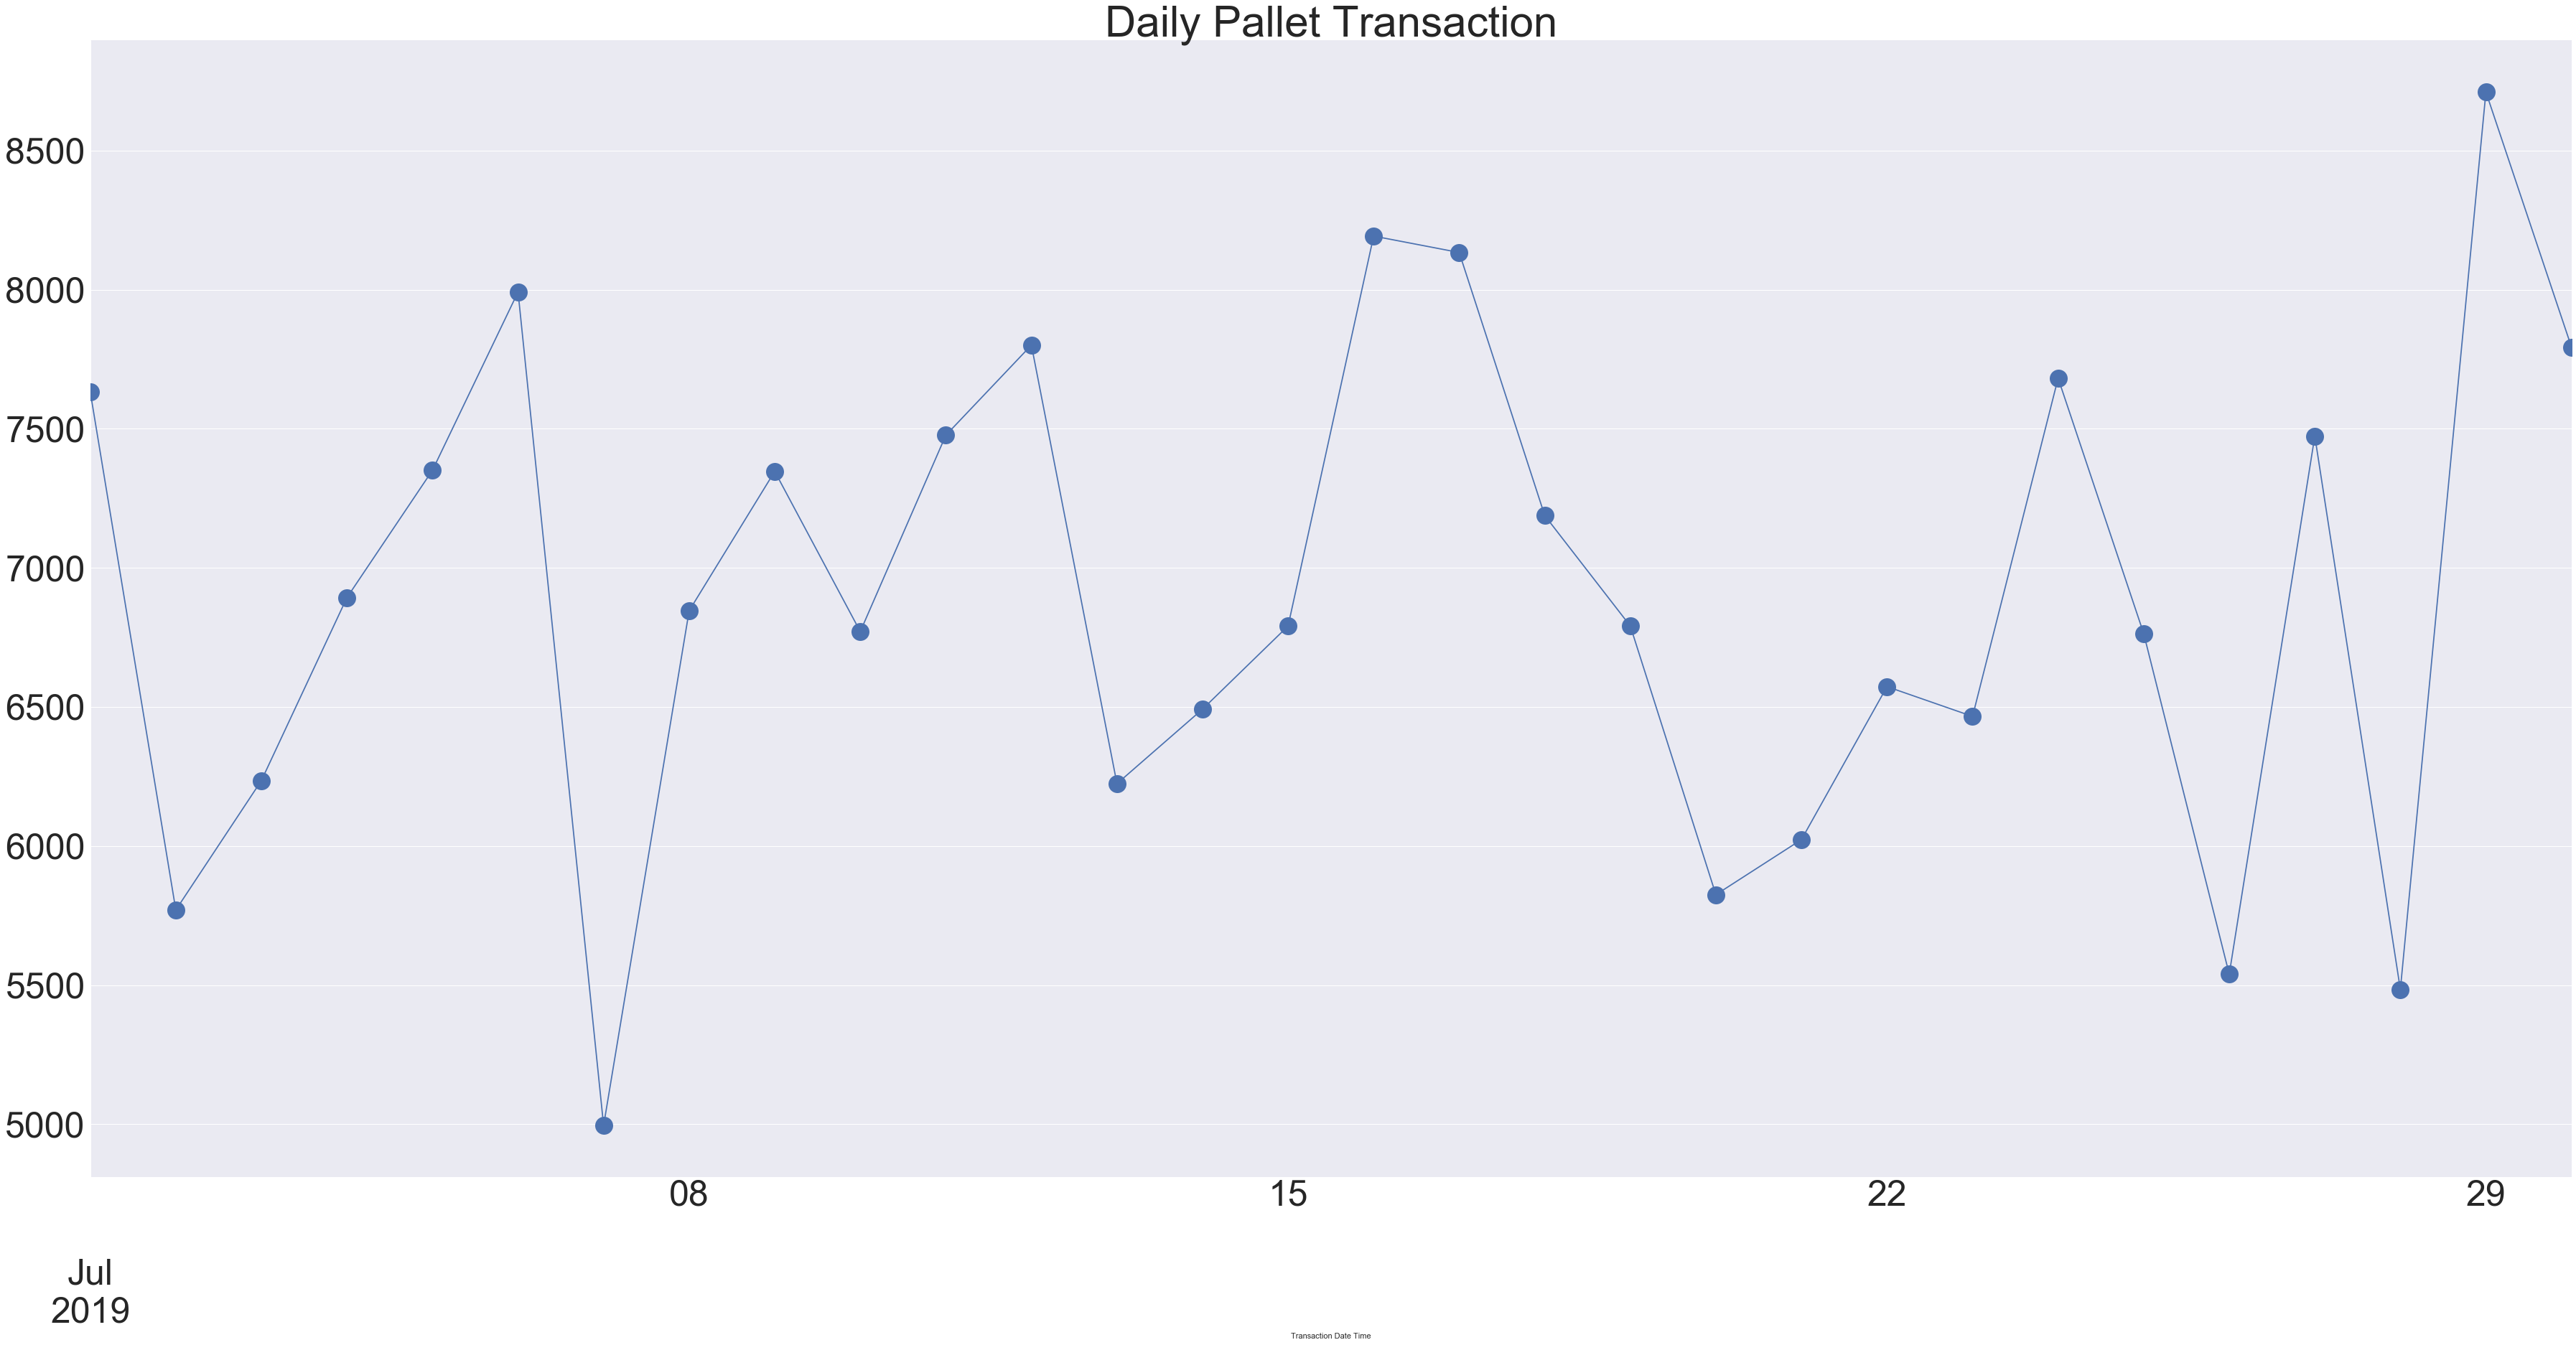

In [83]:
fig=plt.figure()
axes=fig.add_axes([0,0,6,4])
Daily_Transaction.plot(marker='o',ax=axes,fontsize=50,markersize=25)
axes.set_title('Daily Pallet Transaction',fontsize=60)

## Derive Attribute - Shift, Shift_Date

In [84]:
transaction['Day_Shift']=(transaction.index.hour>=7) & (transaction.index.hour<19)

In [85]:
transaction['Shift_Hour']=transaction.index.hour

In [86]:
transaction['Shift_Date']=transaction.index.date

In [87]:
transaction['Shift_Date']=pd.to_datetime(transaction['Shift_Date'],format='%Y-%m-%d')

In [88]:
# handle shift date of night shift with transaction time over 12am
transaction.loc[transaction['Shift_Hour']<7,'Shift_Date']=transaction.loc[transaction['Shift_Hour']<7,'Shift_Date']+datetime.timedelta(days=-1)

In [89]:
transaction.loc[:,'Shift_Date'].sample(5)

Transaction Date Time
2019-07-09 11:45:51   2019-07-09
2019-07-21 08:42:12   2019-07-21
2019-07-29 11:40:55   2019-07-29
2019-07-28 13:51:13   2019-07-28
2019-07-24 23:42:50   2019-07-24
Name: Shift_Date, dtype: datetime64[ns]

## Plot Daily Shift Transaction

In [90]:
daily_shift_transaction=transaction.groupby(['Shift_Date','Day_Shift'])['Pallet Number'].count().reset_index()

In [91]:
daily_shift_transaction['Day_Shift']=daily_shift_transaction['Day_Shift'].map({True:'Dayshift',False:'Nightshift'})

In [92]:
pv_daily_shift_transaction=pd.pivot(data=daily_shift_transaction,index='Shift_Date',columns='Day_Shift',values='Pallet Number')

In [93]:
pv_daily_shift_transaction['Allshift']=pv_daily_shift_transaction.sum(axis='columns')

In [94]:
pv_daily_shift_transaction.head()

Day_Shift,Dayshift,Nightshift,Allshift
Shift_Date,,,
2019-06-30,NaN,2003.0,2003.0
2019-07-01,4105.0,2545.0,6650.0
2019-07-02,3426.0,2553.0,5979.0
2019-07-03,3659.0,2906.0,6565.0
2019-07-04,3786.0,2916.0,6702.0


Text(0.5, 1.0, 'Daily Shift Transaction')

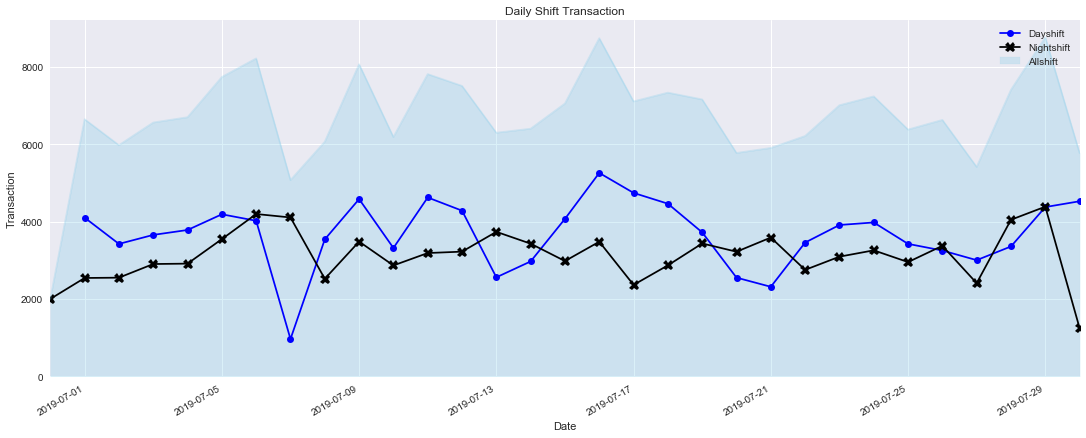

In [95]:
plt.figure(figsize=(15,6))
plt.plot(pv_daily_shift_transaction['Dayshift'],label='Dayshift',marker='o',color='blue')
plt.plot(pv_daily_shift_transaction['Nightshift'],label='Nightshift',marker='X',markersize=10,color='black')
pv_daily_shift_transaction['Allshift'].plot.area(alpha=0.3,color='skyblue')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Transaction')
plt.title('Daily Shift Transaction')

In [96]:
transaction['Shift_Date']=transaction['Shift_Date'].astype('object')

## Plot Distribution of Total Transactions per Pallet

In [97]:
total_transaction_pallet=pd.pivot_table(data=transaction,index='Pallet Number'
                                        ,columns='Username',values='Transaction Date'
                                       ,aggfunc='count').sum(axis='columns')

In [98]:
total_transaction_pallet.sort_values(ascending=False).head(5)

Pallet Number
57413100    77.0
58505262    77.0
57352973    67.0
57438516    66.0
57396304    66.0
dtype: float64

C:\Users\Nan\AppData\Local\conda\conda\envs\env\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


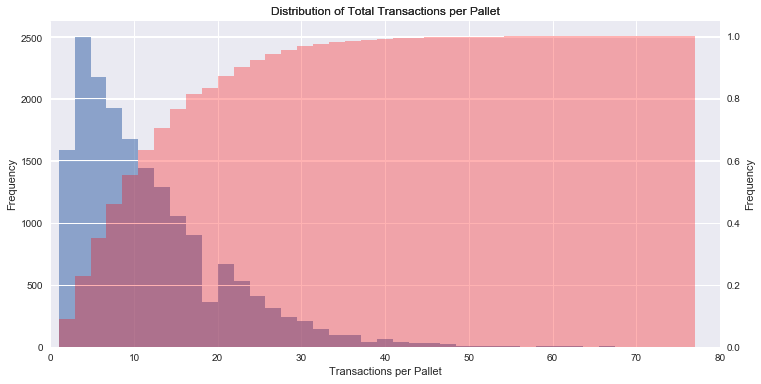

In [99]:
plt.figure(figsize=(12,6))
total_transaction_pallet.plot.hist(bins=40,title='Distribution of Total Transactions per Pallet',alpha=0.6)
plt.xlabel('Transactions per Pallet')
plt.xlim([0,80])

plt.twinx()
total_transaction_pallet.plot.hist(bins=40,title='Distribution of Total Transactions per Pallet',cumulative=True,color='red',alpha=0.3,normed=True)

## New Location

(0, 7000)

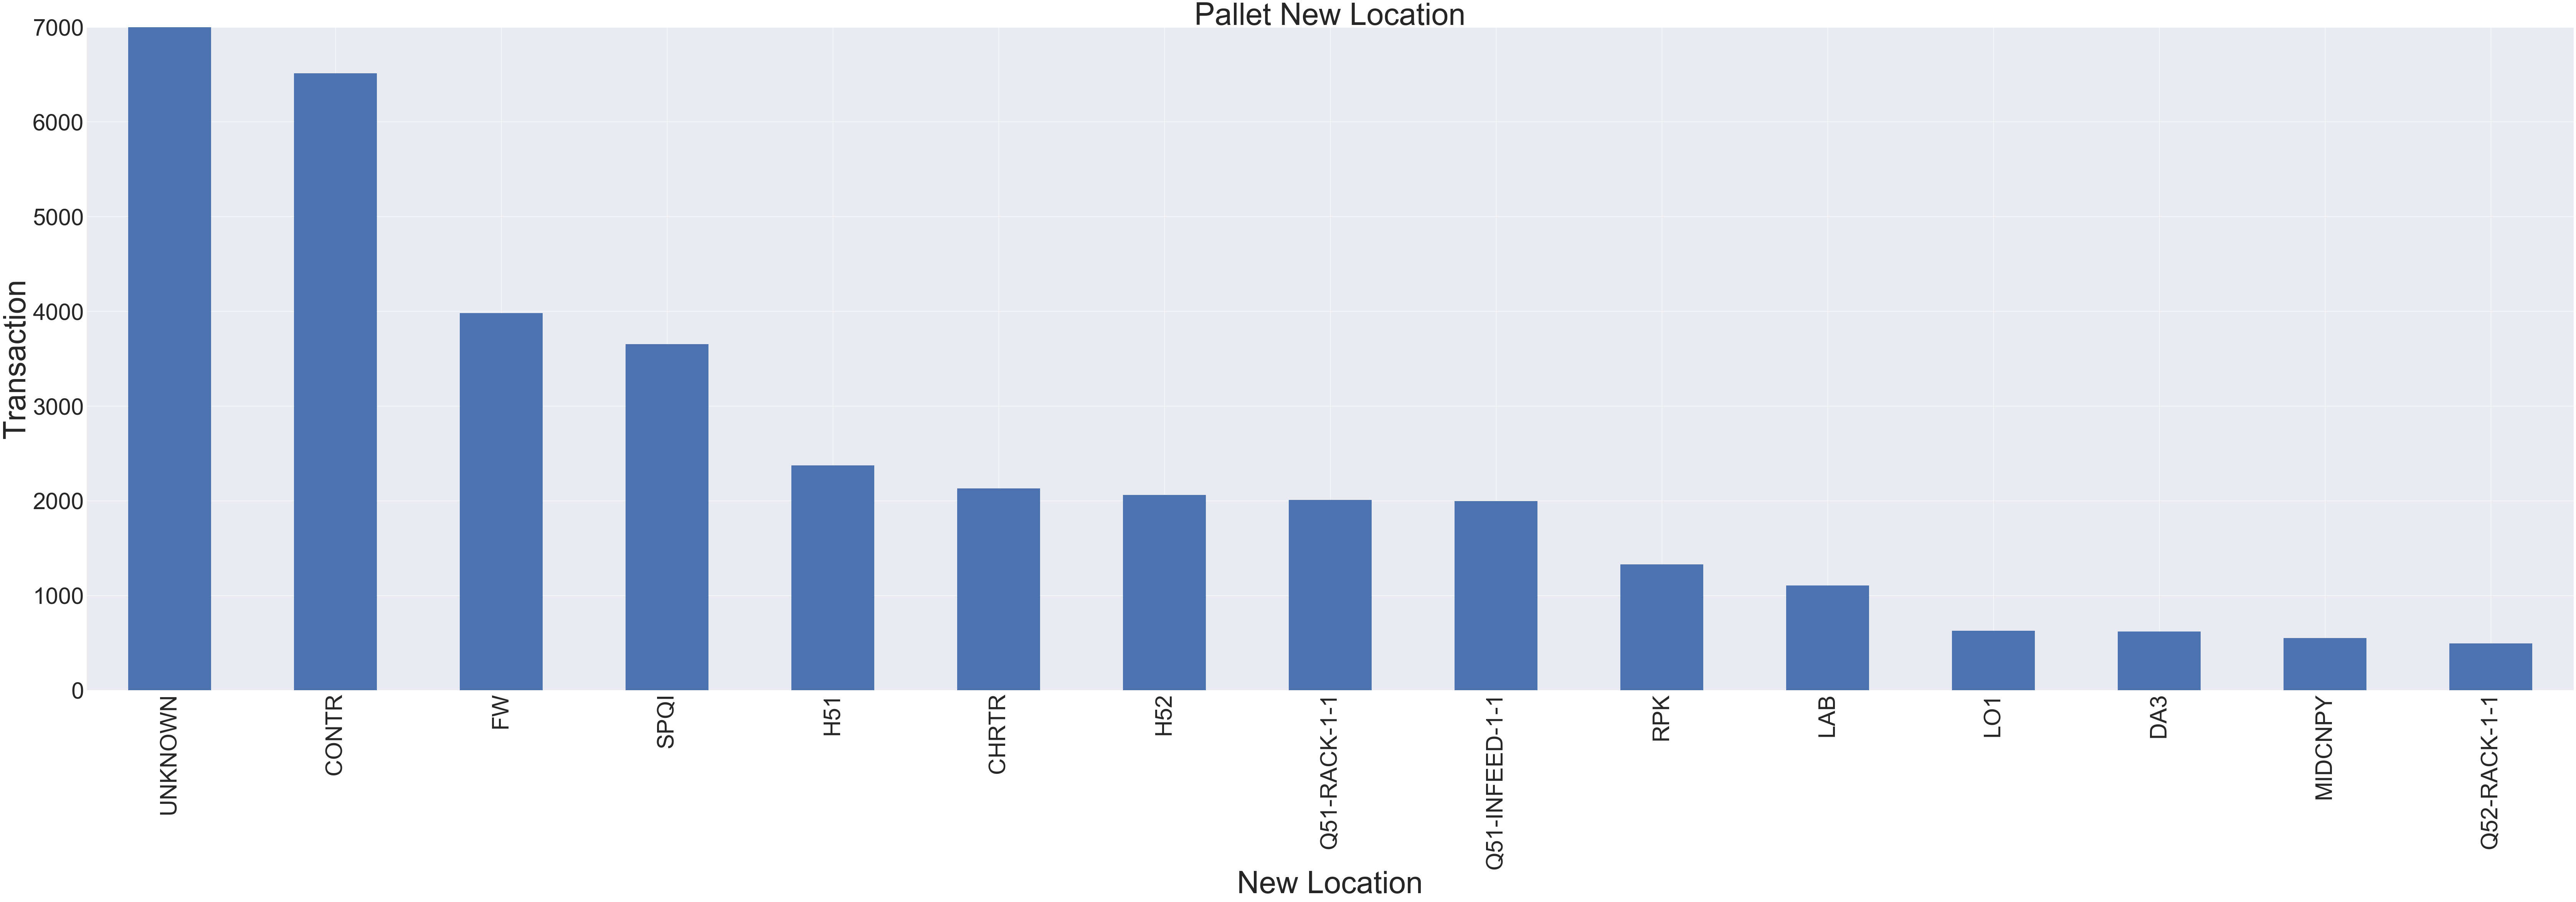

In [100]:
fig=plt.figure(figsize=(15,6))
axes=fig.add_axes([0,0,6,4])
transaction['New Value'].value_counts(dropna=False)[:15].plot(kind='bar',ax=axes,fontsize=60)
axes.set_title('Pallet New Location',fontsize=80)
axes.set_xlabel('New Location',fontsize=80)
axes.set_ylabel('Transaction',fontsize=80)
axes.set_ylim([0,7000])

In [101]:
# ['New Value']=='CONTR'
t_CONTR=transaction.loc[transaction['New Value']=='CONTR',:]

Text(0.5, 1.0, 'Daily Transaction with New Value = CONTR')

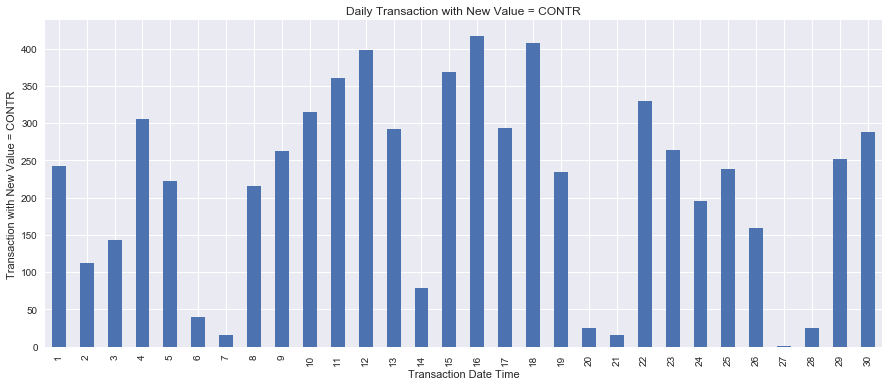

In [102]:
plt.figure(figsize=(15,6))
t_CONTR.groupby(t_CONTR.index.day)['Pallet Number'].count().plot(kind='bar')
plt.ylabel('Transaction with New Value = CONTR')
plt.title('Daily Transaction with New Value = CONTR')

## Location Request Number

In [103]:
#No Relationship between Room and Location Mission Request Destination
# Room = Location Room Code-Location Row Code-Location Column-Location Height
transaction[transaction['Location Mission Request Destination']=='SPQI'][['Room','Location Room Code','Location Row Code','Location Column','Location Height','Location Request Number',
 'Location Mission Request Destination']].sample(10)

,Room,Location Room Code,Location Row Code,Location Column,Location Height,Location Request Number,Location Mission Request Destination
Transaction Date Time,,,,,,,
2019-07-22 13:42:10,CONTR---1,CONTR,NaN,NaN,1.0,1712,SPQI
2019-07-17 08:04:22,UNKNOWN---0,UNKNOWN,NaN,NaN,0.0,1575,SPQI
2019-07-18 17:03:51,CONTR---1,CONTR,NaN,NaN,1.0,1494,SPQI
2019-07-22 00:07:39,UNKNOWN---0,UNKNOWN,NaN,NaN,0.0,1712,SPQI
2019-07-05 01:04:58,CONTR---1,CONTR,NaN,NaN,1.0,1377,SPQI
2019-07-30 09:02:10,Q03-02-4-2,Q03,02,4.0,2.0,1860,SPQI
2019-07-05 21:16:25,Q06-A-1-1,Q06,A,1.0,1.0,1391,SPQI
2019-07-22 07:28:25,CONTR---1,CONTR,NaN,NaN,1.0,1716,SPQI
2019-07-29 04:18:11,Q27-08-2-2,Q27,08,2.0,2.0,1860,SPQI


In [104]:
transaction['Location Request Number'].value_counts().head()

0       138081
1388      3607
1324      2754
1391      1593
1860      1314
Name: Location Request Number, dtype: int64

In [105]:
# total pallet associate with this rqt number is 20, is it possible request number is linked to specified order number?
transaction[transaction['Location Request Number']==1815]['Pallet Number'].unique()

array([58508348, 57383946, 57372612, 57399459, 57390258, 57379642,
       57374746, 57426599, 57427060, 57399909, 57374050, 57392511,
       57438691, 57373244, 57425585, 57438233, 57358296, 57399312,
       57364914, 57350535], dtype=int64)

In [106]:
rqt_number_destination=transaction.groupby('Location Mission Request Destination')['Location Request Number'].value_counts().unstack()
rqt_number_destination=rqt_number_destination.T
rqt_number_destination['Total Transaction']=rqt_number_destination.sum(axis='columns')
rqt_number_destination.head(3)

Location Mission Request Destination,CHRTR,CONTR,CSOF,DA1,DA3,FW,LAB,RPK,SPQI,Total Transaction
Location Request Number,,,,,,,,,,
1228,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,30.0
1229,NaN,NaN,NaN,NaN,NaN,150.0,NaN,NaN,NaN,150.0
1230,NaN,NaN,NaN,NaN,NaN,81.0,NaN,NaN,NaN,81.0


(0, 1000)

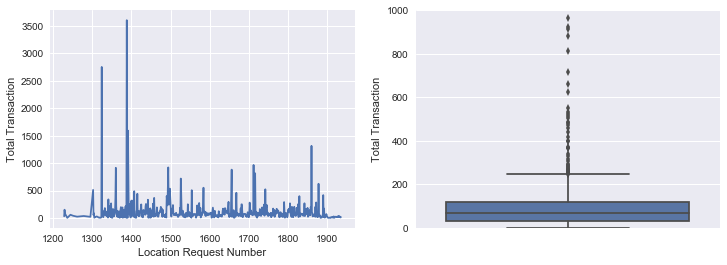

In [107]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=rqt_number_destination.index,y='Total Transaction',data=rqt_number_destination,ax=axes[0])
sns.boxplot(y='Total Transaction',data=rqt_number_destination,ax=axes[1])
plt.ylim([0,1000])

In [108]:
# upon checking, request number with exceptional high transaction are likely valid because there are hundreds of pallet linked to these request number
rqt_number_destination.sort_values(by='Total Transaction',ascending=False).head()

Location Mission Request Destination,CHRTR,CONTR,CSOF,DA1,DA3,FW,LAB,RPK,SPQI,Total Transaction
Location Request Number,,,,,,,,,,
1388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3607.0,3607.0
1324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2754.0,2754.0
1391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1593.0,1593.0
1860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1314.0,1314.0
1712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,966.0,966.0


In [109]:
len(transaction[transaction['Location Request Number']==1388]['Pallet Number'].unique())

267

## Plot Total Transactions of each Mission

In [110]:
total_transc_destination=transaction.pivot_table(index='Location Request Number',columns='Location Mission Request Destination',
                        values='Pallet Number',aggfunc='count')

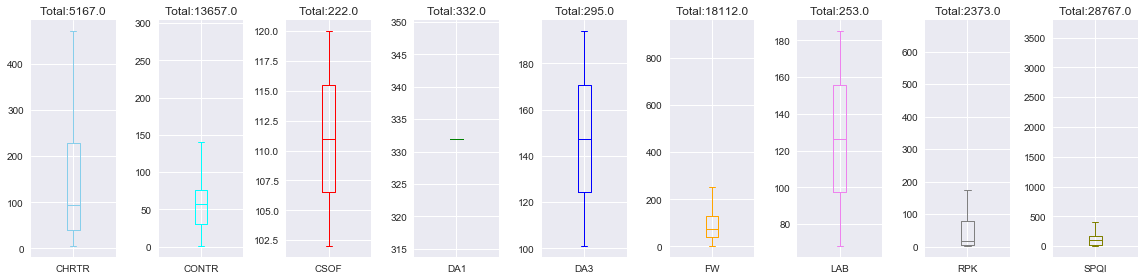

In [111]:
colors=['skyblue','cyan','red','green','blue','orange','violet','grey','olive']

f, axes=plt.subplots(1, len(total_transc_destination.columns), figsize=(16, 4))

for ind,c in enumerate(total_transc_destination.columns):
    #plt.figure(figsize=(16, 4))
    plt.subplot(1,len(total_transc_destination.columns),ind+1)
    total_transc_destination[total_transc_destination[c].notnull()][c].plot.box(color=colors[ind],
                                                                                title='Total:{}'.
                                                                                format(total_transc_destination[total_transc_destination[c]>0][c].sum()))

plt.tight_layout()

In [112]:
# there is only single line in DA1 because there is only one request number attached to DA1
total_transc_destination[total_transc_destination['DA1'].notnull()]

Location Mission Request Destination,CHRTR,CONTR,CSOF,DA1,DA3,FW,LAB,RPK,SPQI
Location Request Number,,,,,,,,,
1442,NaN,NaN,NaN,332.0,NaN,NaN,NaN,NaN,NaN


In [113]:
summary_object(transaction)

SUMMARY OF 34 NON-NUMERICAL ATTRIBUTES:

33 Object Columns
1 Bool Columns


,Attribute,Count,Unique,Missing (%),Top,Top (%),Bottom,Bottom (%)
1,Doi Number,5186,7,97.4978,RT030,1.0967,RT034,0.174178
2,Location Mission Request Destination,69178,10,66.6224,SPQI,13.8797,CSOF,0.107112
3,Location Row Code,84015,55,59.4638,RACK,6.85278,27,0.00530737
4,Location Room Code,207111,59,0.0714082,UNKNOWN,31.3236,LAB,0.000964976
5,Transaction Date,207259,196458,0,18/07/2019 11:19:01 PM,0.00337742,19/07/2019 8:41:28 PM,0.000482488
6,Previous Value,207259,20341,0,UNKNOWN---0,20.8338,ZE04-03-3-2,0.000482488
7,New Value,207259,16767,0,UNKNOWN,22.8178,Q17-24-3-1,0.000482488
8,Room,207259,6516,0,UNKNOWN---0,31.3212,Q23-16-3-1,0.000482488
9,Material Number,207259,266,0,62845,5.69143,E5003,0.000482488
10,Pack Date,207259,103,0,19/04/2019 12:00:00 AM,5.30158,19/03/2019 12:00:00 AM,0.000482488


## Location ended with symbol '---' in Previous Value and Room

In [114]:
t_p_value=transaction['Previous Value'].value_counts().sort_values(ascending=False)
t_n_value=transaction['New Value'].value_counts().sort_values(ascending=False)

In [115]:
t_p_value=t_p_value.to_frame()
t_n_value=t_n_value.to_frame()

In [116]:
t_p_value.reset_index(inplace=True)
t_n_value.reset_index(inplace=True)

In [117]:
pd.merge(left=t_p_value,right=t_n_value,left_on=t_p_value.index,right_on=t_n_value.index).head()

,key_0,index_x,Previous Value,index_y,New Value
0,0,UNKNOWN---0,43180,UNKNOWN,47292
1,1,CONTR---1,3808,CONTR,6514
2,2,FW---1,3773,FW,3979
3,3,SPQI---1,3645,SPQI,3653
4,4,H52---1,2054,H51,2373


In [118]:
del t_p_value,t_n_value

In [119]:
transaction['Previous Value']=transaction['Previous Value'].apply(lambda x:str(x).split('---')[0] if '---' in str(x) else x)

## Replace Missing Data in Location Row Code, Column and Height with na

In [120]:
# Location Row Code and Column are NaN because Location Room Code is UNKNOWN
# the other reason these data is NaN because the Room Code is FW.CONTR etc.
# transaction[['Pallet Number','Location Room Code','Location Column','Location Row Code','Location Height']].sample(5)

In [121]:
transaction.loc[transaction['Location Row Code'].isna(),'Location Row Code']='na'

In [122]:
transaction.loc[transaction['Location Column'].isna(),'Location Column']='na'

In [123]:
transaction.loc[transaction['Location Height'].isna(),'Location Height']='na'

In [124]:
transaction[transaction['Location Height'].isna()][['Location Room Code','Location Row Code',
                                                    'Location Column','Location Height']].head()

,Location Room Code,Location Row Code,Location Column,Location Height
Transaction Date Time,,,,


## Replace Doi Number with True/ False

In [125]:
transaction['DOI_Number']=transaction['Doi Number'].notna()

In [126]:
transaction.drop(columns='Doi Number',axis='columns',inplace=True)

## Replace Data with Missing Request Destination with 'na'

In [127]:
transaction.loc[transaction['Location Mission Request Destination'].isna(),'Location Mission Request Destination']='na'

In [128]:
transaction['Location Mission Request Destination'].value_counts()

na       138081
SPQI      28767
FW        18112
CONTR     13657
CHRTR      5167
RPK        2373
DA1         332
DA3         295
LAB         253
CSOF        222
Name: Location Mission Request Destination, dtype: int64

## Missing Data in Location Room Code with UNKNOWN

In [129]:
transaction[transaction['Location Room Code'].isna()][['Room','Location Room Code',
                                                       'Location Column','Location Row Code',
                                                       'Previous Value','New Value']].head()

,Room,Location Room Code,Location Column,Location Row Code,Previous Value,New Value
Transaction Date Time,,,,,,
2019-07-01 14:39:58,---,NaN,na,na,Q07-14-5-1,UNKNOWN
2019-07-02 09:28:31,---,NaN,na,na,Q04-07-5-2,Q04-08-5-2
2019-07-02 09:29:39,---,NaN,na,na,Q04-08-5-2,UNKNOWN
2019-07-02 09:29:41,---,NaN,na,na,UNKNOWN,DA1
2019-07-02 09:55:21,---,NaN,na,na,DA1,UNKNOWN


In [130]:
transaction[transaction['Location Room Code']=='UNKNOWN'][['Room','Location Room Code',
                                                       'Location Column','Location Row Code',
                                                       'Previous Value','New Value']].head()

,Room,Location Room Code,Location Column,Location Row Code,Previous Value,New Value
Transaction Date Time,,,,,,
2019-07-01 00:00:10,UNKNOWN---0,UNKNOWN,na,na,Q02-03-3-1,Q02-03-4-1
2019-07-01 00:00:29,UNKNOWN---0,UNKNOWN,na,na,Q14-02-7-1,Q14-02-10-1
2019-07-01 00:00:39,UNKNOWN---0,UNKNOWN,na,na,ALLO,UNKNOWN
2019-07-01 00:00:44,UNKNOWN---0,UNKNOWN,na,na,Q02-03-4-1,Q02-16-6-2
2019-07-01 00:01:03,UNKNOWN---0,UNKNOWN,na,na,Q02-03-2-2,Q02-03-3-2


In [131]:
transaction.loc[transaction['Location Room Code'].isna(),'Location Room Code']='UNKNOWN'

## Handle '---' in transaction['Room']

In [132]:
transaction['Room'].value_counts().head()

UNKNOWN---0     64916
CONTR---1       41769
Q51-RACK-1-1    11277
FW---1           3591
CHRTR---1        3539
Name: Room, dtype: int64

In [133]:
transaction.loc[transaction['Room']=='---','Room']='UNKNOWN'

In [134]:
transaction['Room']=transaction['Room'].apply(lambda x : str(x).split('---')[0] if  '---' in x else x)

In [135]:
summary_object(transaction)

SUMMARY OF 36 NON-NUMERICAL ATTRIBUTES:

34 Object Columns
2 Bool Columns


,Attribute,Count,Unique,Missing (%),Top,Top (%),Bottom,Bottom (%)
1,Transaction Date,207259,196458,0,18/07/2019 11:19:01 PM,0.00337742,19/07/2019 8:41:28 PM,0.000482488
2,Previous Value,207259,20331,0,UNKNOWN,21.7168,ZD03-04-1-1,0.000482488
3,New Value,207259,16767,0,UNKNOWN,22.8178,Q17-24-3-1,0.000482488
4,Room,207259,6510,0,UNKNOWN,31.395,Q11-08-9-2,0.000482488
5,Material Number,207259,266,0,62845,5.69143,E5003,0.000482488
6,Pack Date,207259,103,0,19/04/2019 12:00:00 AM,5.30158,19/03/2019 12:00:00 AM,0.000482488
7,Pack Type,207259,69,0,ENMLKC6,21.0268,ENITKC4,0.000964976
8,Username,207259,68,0,agubs,5.62822,elliot,0.000482488
9,Location Room Code,207259,58,0,UNKNOWN,31.395,LAB,0.000964976
10,Location Row Code,207259,55,0,na,59.4638,27,0.00530737


In [136]:
summary_numerical(transaction)

SUMMARY OF 11 NUMERICAL ATTRIBUTES:


,Attribute,Count,Missing (%),Mean,Median,Min,Max,Skewness,Kurtosis
1,Pallet Number,207259.0,0.0,5.892474e+07,57683916.0,53179215.0,9.800255e+07,6.107799,40.722952
2,Pallet Rework Count,207259.0,0.0,1.781491e-01,0.0,0.0,5.000000e+00,4.166364,17.708424
3,Fruit Per Pack,207259.0,0.0,5.575803e+01,48.0,18.0,4.970000e+02,2.406976,18.491380
4,Pack Code,207259.0,0.0,1.930413e+04,10308.0,0.0,7.633200e+04,1.390299,1.243447
5,Location Request Number,207259.0,0.0,5.255148e+02,0.0,0.0,1.935000e+03,0.766228,-1.327388
6,Packed Fruit,207259.0,0.0,7.895287e+03,7656.0,-5916.0,2.035500e+04,0.120598,0.936007
7,Fruit,207259.0,0.0,7.969990e+03,7680.0,0.0,1.562000e+04,0.048472,0.731638
8,Shift_Hour,207259.0,0.0,1.207310e+01,12.0,0.0,2.300000e+01,-0.067395,-1.060507
9,Packs,207259.0,0.0,1.691822e+02,160.0,0.0,2.560000e+02,-0.152523,-0.888059
10,Trays,207259.0,0.0,2.556747e+02,256.0,0.0,3.404762e+02,-1.859026,7.992295


## =========No more missing data in transactional dataset=========

In [131]:
# Dispatched

In [132]:
dispatched.head(3)

,Pallet Number,Location Room Code,Location Row Code,Location Column,Location Height,Location Request Number,Location Mission Request Destination,Storage Source Code,Pack Label Code,Pack Indicator Code,Clearance Protocol Code,Customer Label Code,Ppqi Passed,Dry Matter Code,Storing Characteristic Code,Storing Characteristic Description,CCKPassed Failed,Quality Inspection Indicator Code,Japan Sub Brand Code,Trial Packing Indicator Code,Marketer Code,Loadout Priority,Material Number,Material Mnemonic,Material Group Code,Brand Code,Variety Code,Fruit Class Code,Fruit Class Description,Fruit Size Code,Pack Category Code,Labelling Indicator Code,Purchase Pool Code,Pack Code,Growing Method,Packs Per Pallet,Maturity Indicator Code,Plant Code,Ignore Psr,Pack Type Code,Packed Fruit,Packed Trays,Packhouse Code,Pallet Card Reference,Fruit,Order Number,Order Line Number,Shipment Type Code,Destination Port Code,Trucking Company Code,Packs,Tray Equivalent,Kg,Full,Market Holds,Internal Holds,Stacking Configuration Code,Pack Style Code,Pack Make Code,Pack Iso,Pack Week,Rf Id Tag1,Doi Number,Envelope Number,Pallet Equivalents,Container,Container Number,Temperature Recorder Number,Temporary Seal Number,Permanent Seal Number,Pallet Note,Repack_Date_day,Last_Spqi_Date_day,Pack_Date_day,Ok_Until_Date_day,Load_Start_Date_hour,Tkl_Email_Date_day
Loadout Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-23 00:45:00,54989127,UNKNOWN,NaN,NaN,0.0,NaN,NaN,CN,N,N,A,N,NaN,Y,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,NaN,A,N,N,ZIL,20,61600,ENIJ22CK1GAZNZJB0,Zespri,Z,GA,1,Class 1,22,ENIJ,JB,16,10168,CK,200,B,1103,False,ENIJKC3,4400,200.0,3TPP,1123NIGHT,4400,5153301,20,1,CNSHG,FMBT,200,200.0,715.0,True,"ID, IN, KR, RE, TW, Z7",NaN,N,IJ,KC3,124,12,NaN,NaN,193012,1.0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,-3.0,42.0,-0.0,NaN
2019-03-23 00:45:00,54990543,UNKNOWN,NaN,NaN,0.0,NaN,NaN,CN,N,N,A,N,NaN,Y,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,NaN,A,N,N,ZIL,20,61600,ENIJ22CK1GAZNZJB0,Zespri,Z,GA,1,Class 1,22,ENIJ,JB,16,10168,CK,200,B,1103,False,ENIJKC3,4400,200.0,3TPP,1124DAY,4400,5153301,20,1,CNSHG,FMBT,200,200.0,715.0,True,NaN,NaN,N,IJ,KC3,124,12,NaN,NaN,193012,1.0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,-3.0,42.0,-0.0,NaN
2019-03-23 00:45:00,54990321,UNKNOWN,NaN,NaN,0.0,NaN,NaN,CN,N,N,A,N,NaN,Y,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,NaN,A,N,N,ZIL,20,61600,ENIJ22CK1GAZNZJB0,Zespri,Z,GA,1,Class 1,22,ENIJ,JB,16,10168,CK,200,B,1103,False,ENIJKC3,4400,200.0,3TPP,1124DAY,4400,5153301,20,1,CNSHG,FMBT,200,200.0,715.0,True,NaN,NaN,N,IJ,KC3,124,12,NaN,NaN,193012,1.0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,-3.0,42.0,-0.0,NaN


In [133]:
summary_object(dispatched)

SUMMARY OF 47 NON-NUMERICAL ATTRIBUTES:

44 Object Columns
3 Bool Columns


,Attribute,Count,Unique,Missing (%),Top,Top (%),Bottom,Bottom (%)
1,Ppqi Passed,2,2,99.9938,False,0.00620136,False,0.00620136
2,Permanent Seal Number,176,14,99.4543,Z2810703,0.0620136,z2810709,0.0155034
3,Location Mission Request Destination,257,4,99.2031,CONTR,0.772069,SPQI,0.00310068
4,Doi Number,488,7,98.4869,MF030,0.368981,RT034,0.114725
5,Location Row Code,1157,28,96.4125,16,0.31937,REJECT,0.00310068
6,Internal Holds,3345,22,89.6282,ID,5.60603,"IB, TI",0.00310068
7,CCKPassed Failed,4849,3,84.9648,True,13.1407,False,1.89451
8,Temporary Seal Number,19672,1042,39.0034,T176830,0.0620136,T174392,0.00310068
9,Temperature Recorder Number,19705,1030,38.9011,0,0.260457,FH61C00JW0,0.00310068
10,Container Number,19848,1050,38.4577,TTNU8955756,0.124027,OOLU6164164,0.00310068


In [134]:
summary_numerical(dispatched)

SUMMARY OF 30 NUMERICAL ATTRIBUTES:


,Attribute,Count,Missing (%),Mean,Median,Min,Max,Skewness,Kurtosis
1,Location Request Number,257.0,99.203125,1.925529e+03,1.922000e+03,1.815000e+03,2.065000e+03,NaN,NaN
2,Repack_Date_day,717.0,97.776813,-5.856346e+00,-5.000000e+00,-3.800000e+01,-1.000000e+00,NaN,NaN
3,Location Column,1157.0,96.412514,6.375108e+00,6.000000e+00,1.000000e+00,1.300000e+01,NaN,NaN
4,Rf Id Tag1,4072.0,87.374035,5.366426e+06,5.385446e+06,5.079720e+05,5.417305e+06,NaN,NaN
5,Last_Spqi_Date_day,4874.0,84.887290,-9.365819e+00,-9.000000e+00,-6.600000e+01,-1.000000e+00,NaN,NaN
6,Tkl_Email_Date_day,7052.0,78.134011,-3.370959e+00,-3.000000e+00,-9.000000e+00,-1.000000e+00,NaN,NaN
7,Container,19848.0,38.457722,6.625299e+03,7.985000e+03,1.000000e+02,9.979000e+03,NaN,NaN
8,Location Height,32225.0,0.080618,4.810551e-01,0.000000e+00,0.000000e+00,2.000000e+00,NaN,NaN
9,Fruit Class Code,32251.0,0.000000,1.025798e+00,1.000000e+00,1.000000e+00,3.000000e+00,7.644305,64.191154
10,Pallet Number,32251.0,0.000000,5.773843e+07,5.713356e+07,5.317046e+07,9.850013e+07,6.468079,49.061724


## Replace Missing data in Row Code & Column with na

In [135]:
#[['Location Room Code','Location Row Code','Location Column','Location Height','Location Request Number']]

In [136]:
dispatched[dispatched['Location Row Code'].isna()]['Location Room Code'].value_counts().head()

UNKNOWN    17153
LO2         6440
CONTR       3111
ALLO        2858
LO1          972
Name: Location Room Code, dtype: int64

In [137]:
dispatched.loc[dispatched['Location Row Code'].isna(),['Location Row Code','Location Column','Location Height']]='na'

In [138]:
dispatched.loc[dispatched['Location Room Code'].isna(),'Location Room Code']='UNKNOWN'

## Replace missing data in 'Container' and 'Container Number' with na, represent chartered

In [139]:
dispatched.loc[dispatched['Container'].isna(),'Shipment Type Code'].value_counts()

1     12002
5       380
15       16
23        4
3         1
Name: Shipment Type Code, dtype: int64

In [140]:
dispatched.loc[dispatched['Container'].notnull(),'Shipment Type Code'].value_counts()

18    15296
4      3551
2       619
11      382
Name: Shipment Type Code, dtype: int64

In [141]:
dispatched.loc[dispatched['Container'].isna(),['Container','Container Number']]='na'

## Replace missing data in 'Location Request Number' and 'Location Mission Request Destination' with na

In [142]:
dispatched[dispatched['Location Request Number'].isna()]['Location Mission Request Destination'].unique()

array([nan], dtype=object)

In [143]:
dispatched.loc[dispatched['Location Request Number'].isna(),['Location Request Number','Location Mission Request Destination']]='na'

## Replace missing data in Repack_Date_day,Tkl_Email_Date_day,Last_Spqi_Date_day with 0

In [144]:
dispatched.head(2)

,Pallet Number,Location Room Code,Location Row Code,Location Column,Location Height,Location Request Number,Location Mission Request Destination,Storage Source Code,Pack Label Code,Pack Indicator Code,Clearance Protocol Code,Customer Label Code,Ppqi Passed,Dry Matter Code,Storing Characteristic Code,Storing Characteristic Description,CCKPassed Failed,Quality Inspection Indicator Code,Japan Sub Brand Code,Trial Packing Indicator Code,Marketer Code,Loadout Priority,Material Number,Material Mnemonic,Material Group Code,Brand Code,Variety Code,Fruit Class Code,Fruit Class Description,Fruit Size Code,Pack Category Code,Labelling Indicator Code,Purchase Pool Code,Pack Code,Growing Method,Packs Per Pallet,Maturity Indicator Code,Plant Code,Ignore Psr,Pack Type Code,Packed Fruit,Packed Trays,Packhouse Code,Pallet Card Reference,Fruit,Order Number,Order Line Number,Shipment Type Code,Destination Port Code,Trucking Company Code,Packs,Tray Equivalent,Kg,Full,Market Holds,Internal Holds,Stacking Configuration Code,Pack Style Code,Pack Make Code,Pack Iso,Pack Week,Rf Id Tag1,Doi Number,Envelope Number,Pallet Equivalents,Container,Container Number,Temperature Recorder Number,Temporary Seal Number,Permanent Seal Number,Pallet Note,Repack_Date_day,Last_Spqi_Date_day,Pack_Date_day,Ok_Until_Date_day,Load_Start_Date_hour,Tkl_Email_Date_day
Loadout Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-23 00:45:00,54989127,UNKNOWN,na,na,na,na,na,CN,N,N,A,N,NaN,Y,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,NaN,A,N,N,ZIL,20,61600,ENIJ22CK1GAZNZJB0,Zespri,Z,GA,1,Class 1,22,ENIJ,JB,16,10168,CK,200,B,1103,False,ENIJKC3,4400,200.0,3TPP,1123NIGHT,4400,5153301,20,1,CNSHG,FMBT,200,200.0,715.0,True,"ID, IN, KR, RE, TW, Z7",NaN,N,IJ,KC3,124,12,NaN,NaN,193012,1.0,na,na,NaN,NaN,NaN,False,NaN,NaN,-3.0,42.0,-0.0,NaN
2019-03-23 00:45:00,54990543,UNKNOWN,na,na,na,na,na,CN,N,N,A,N,NaN,Y,P,KiwiStart Submit any Wk ? Ship by Wk 21 Mainpa...,NaN,A,N,N,ZIL,20,61600,ENIJ22CK1GAZNZJB0,Zespri,Z,GA,1,Class 1,22,ENIJ,JB,16,10168,CK,200,B,1103,False,ENIJKC3,4400,200.0,3TPP,1124DAY,4400,5153301,20,1,CNSHG,FMBT,200,200.0,715.0,True,NaN,NaN,N,IJ,KC3,124,12,NaN,NaN,193012,1.0,na,na,NaN,NaN,NaN,False,NaN,NaN,-3.0,42.0,-0.0,NaN


In [145]:
dispatched.loc[dispatched['Repack_Date_day'].isna(),'Repack_Date_day']=0

In [146]:
dispatched.loc[dispatched['Tkl_Email_Date_day'].isna(),'Tkl_Email_Date_day']=0
dispatched.loc[dispatched['Last_Spqi_Date_day'].isna(),'Last_Spqi_Date_day']=0

## dispatched : filter out subset of important attribure

In [147]:
dispatched_short=['Pallet Number',
'Location Room Code', 'Location Row Code','Location Column', 'Location Height',
'Loadout Priority',
'Purchase Pool Code',
'Pack Code','Pack Type Code', 'Stacking Configuration Code',
'Order Number', 'Order Line Number','Envelope Number',
'Container', 'Container Number',
'Shipment Type Code', 'Destination Port Code', 'Trucking Company Code',
'Location Request Number','Location Mission Request Destination','Pallet Note',
 'Repack_Date_day',
 'Last_Spqi_Date_day',
 'Pack_Date_day',
 'Ok_Until_Date_day',
 'Load_Start_Date_hour',
 'Tkl_Email_Date_day']

In [148]:
dispatched_s=dispatched[dispatched_short]

In [149]:
summary_numerical(dispatched_s)

SUMMARY OF 13 NUMERICAL ATTRIBUTES:


,Attribute,Count,Missing (%),Mean,Median,Min,Max,Skewness,Kurtosis
1,Pallet Number,32251.0,0.0,5.773843e+07,57133558.0,53170465.0,98500127.0,6.468079,49.061724
2,Order Line Number,32251.0,0.0,6.062736e+01,50.0,10.0,416.0,1.868766,5.132528
3,Loadout Priority,32251.0,0.0,1.387176e+01,7.0,1.0,50.0,1.493085,2.048989
4,Pack Code,32251.0,0.0,2.122381e+04,10309.0,0.0,76332.0,1.370836,1.101438
5,Envelope Number,32251.0,0.0,1.955233e+05,193898.0,193001.0,199331.0,0.400575,-1.535522
6,Shipment Type Code,32251.0,0.0,9.587579e+00,4.0,1.0,23.0,0.034331,-1.944147
7,Ok_Until_Date_day,32251.0,0.0,2.156473e+01,23.0,-2.0,46.0,-0.006213,-1.317638
8,Pack_Date_day,32251.0,0.0,-3.046299e+01,-20.0,-116.0,-1.0,-1.198677,0.381977
9,Load_Start_Date_hour,32251.0,0.0,-2.685076e+01,-31.0,-456.0,88.0,-2.094641,23.929074
10,Tkl_Email_Date_day,32251.0,0.0,-7.370934e-01,0.0,-9.0,0.0,-2.280274,4.834074


In [ ]:
dispatched_s.shape

## Merge transaction with dispatched_s

In [ ]:
dispatched_s.reset_index(inplace=True)

In [ ]:
transaction.reset_index(inplace=True)

In [ ]:
merge_dispatch=transaction.merge(dispatched_s,on='Pallet Number')
merge=transaction.merge(dispatched_s,on='Pallet Number',how='left')

In [ ]:
merge_dispatch.to_csv('merge_dispatch.csv',index=False)
merge.to_csv('merge.csv',index=False)

In [ ]:
len(merge_dispatch_only['Pallet Number'].unique())

In [ ]:
merge_dispatch['Location Mission Request Destination_x'].value_counts(dropna=False)

In [ ]:
summary_object(transaction)

In [ ]:
daily_loadout=dispatched[['Pallet Number']].resample('D').count()

In [ ]:
daily_loadout_july=daily_loadout.loc['July 2019',:]

In [ ]:
daily_loadout_july.plot(kind='bar')

In [ ]:
[c for c in dispatched.columns if 'Date' in c]

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(daily_loadout_july['Pallet Number'],marker='o',markerfacecolor='r')
plt.title('Daily Loadout in July 2019',fontsize=20)
plt.ylabel('Pallet Quantity')
x_tick_value=daily_loadout['July 2019'].index.tolist()
x_tick_label=daily_loadout['July 2019'].index.date.tolist()

In [ ]:
plt.figure(figsize=(15,6))
dispatched['Location Room Code'].value_counts(normalize=False,dropna=False).head(10).plot(kind='bar')
plt.xlabel('Location Room Code')
plt.ylabel('Transaction')
plt.title('Top 10 Location Room Code of Dispatched Pallet')

In [ ]:
daily_loadout['July 2019'].sum()

## Pallet in Both Datasets

In [ ]:
pallet_in_transaction=transaction['Pallet Number'].unique()
len(pallet_in_transaction)

In [ ]:
pallet_in_dispatched=dispatched['Pallet Number'].unique()
len(pallet_in_dispatched)

In [ ]:
pallet_in_both=[c for c in pallet_in_dispatched if c in pallet_in_transaction]

In [ ]:
len(pallet_in_both)

In [ ]:
transaction['Location Height'].value_counts()